NASA Jet Fan Engine Remaining Usable Life(RUL)

In [86]:
# %%

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler,StandardScaler
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, Math, Latex





In [87]:
# Load data
FD001_data = pd.read_csv('CMAPSSData/train_FD001.txt',delim_whitespace=True)
pd.set_option('display.max_rows', None)

#FD001_data.info()

# List of sensor names
sensor_names =['Fan inlet temperature ◦R', 'LPC outlet temperature ◦R', 
'HPC outlet temperature ◦R', 'LPT outlet temperature ◦R',
'Fan inlet Pressure psia', 'bypass-duct pressure psia',
'HPC outlet pressure psia', 'Physical fan speed rpm',
'Physical core speed rpm', 'Engine pressure ratioP50/P2',
'HPC outlet Static pressure psia', 'Ratio of fuel flow to Ps30 pps/psia',
'Corrected fan speed rpm', 'Corrected core speed rpm', 'Bypass Ratio ', 
'Burner fuel-air ratio', 'Bleed Enthalpy', 'Required fan speed', 
'Required fan conversion speed', 'High-pressure turbines Cool air flow', 
'Low-pressure turbines Cool air flow']

#Setting dict to store new names for colummns 
operational_dict = {
    '1':'Engine',
    '1.1':'Cycles',
    '-0.0007': 'Operational Setting 1',
    '-0.0004': 'Operational Setting 2',
    '100.0': 'Operational Setting 3',
}

#Creating a list of columns names
old_columns = list(FD001_data.columns)

#Removing column names found in operational_dict
operational_columns_to_rename = [col for col in old_columns if col not in operational_dict.keys()]

#Combining the two lists into a dict using tuple type casting
converged_names = dict(map(lambda i,j : (i,j) , operational_columns_to_rename,sensor_names))

# Combine both dictionaries (operational_dict and converged_names) ** is just short hand combining of the dictionary
all_rename_dict = {**operational_dict, **converged_names}

# Renaming columns in the dataframe
FD001_data.rename(columns=all_rename_dict, inplace=True)
print(FD001_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

Skewness of Fan inlet temperature ◦R: 0.0
Skewness of LPC outlet temperature ◦R: 0.316583501137655
Skewness of HPC outlet temperature ◦R: 0.3089193176181448
Skewness of LPT outlet temperature ◦R: 0.4431150548728743
Skewness of Fan inlet Pressure psia: 0.0
Skewness of bypass-duct pressure psia: -6.916635002907901
Skewness of HPC outlet pressure psia: -0.3942606916976628
Skewness of Physical fan speed rpm: 0.47934011995066556
Skewness of Physical core speed rpm: 2.5553469250442564
Skewness of Engine pressure ratioP50/P2: 0.0
Skewness of HPC outlet Static pressure psia: 0.4692823094660817
Skewness of Ratio of fuel flow to Ps30 pps/psia: -0.4423533166145076
Skewness of Corrected fan speed rpm: 0.46972290073323913
Skewness of Corrected core speed rpm: 2.3724704578719185
Skewness of Bypass Ratio : 0.3881823266382687
Skewness of Burner fuel-air ratio: 0.0
Skewness of Bleed Enthalpy: 0.35304226645162856
Skewness of Required fan speed: 0.0
Skewness of Required fan conversion speed: 0.0
Skewness

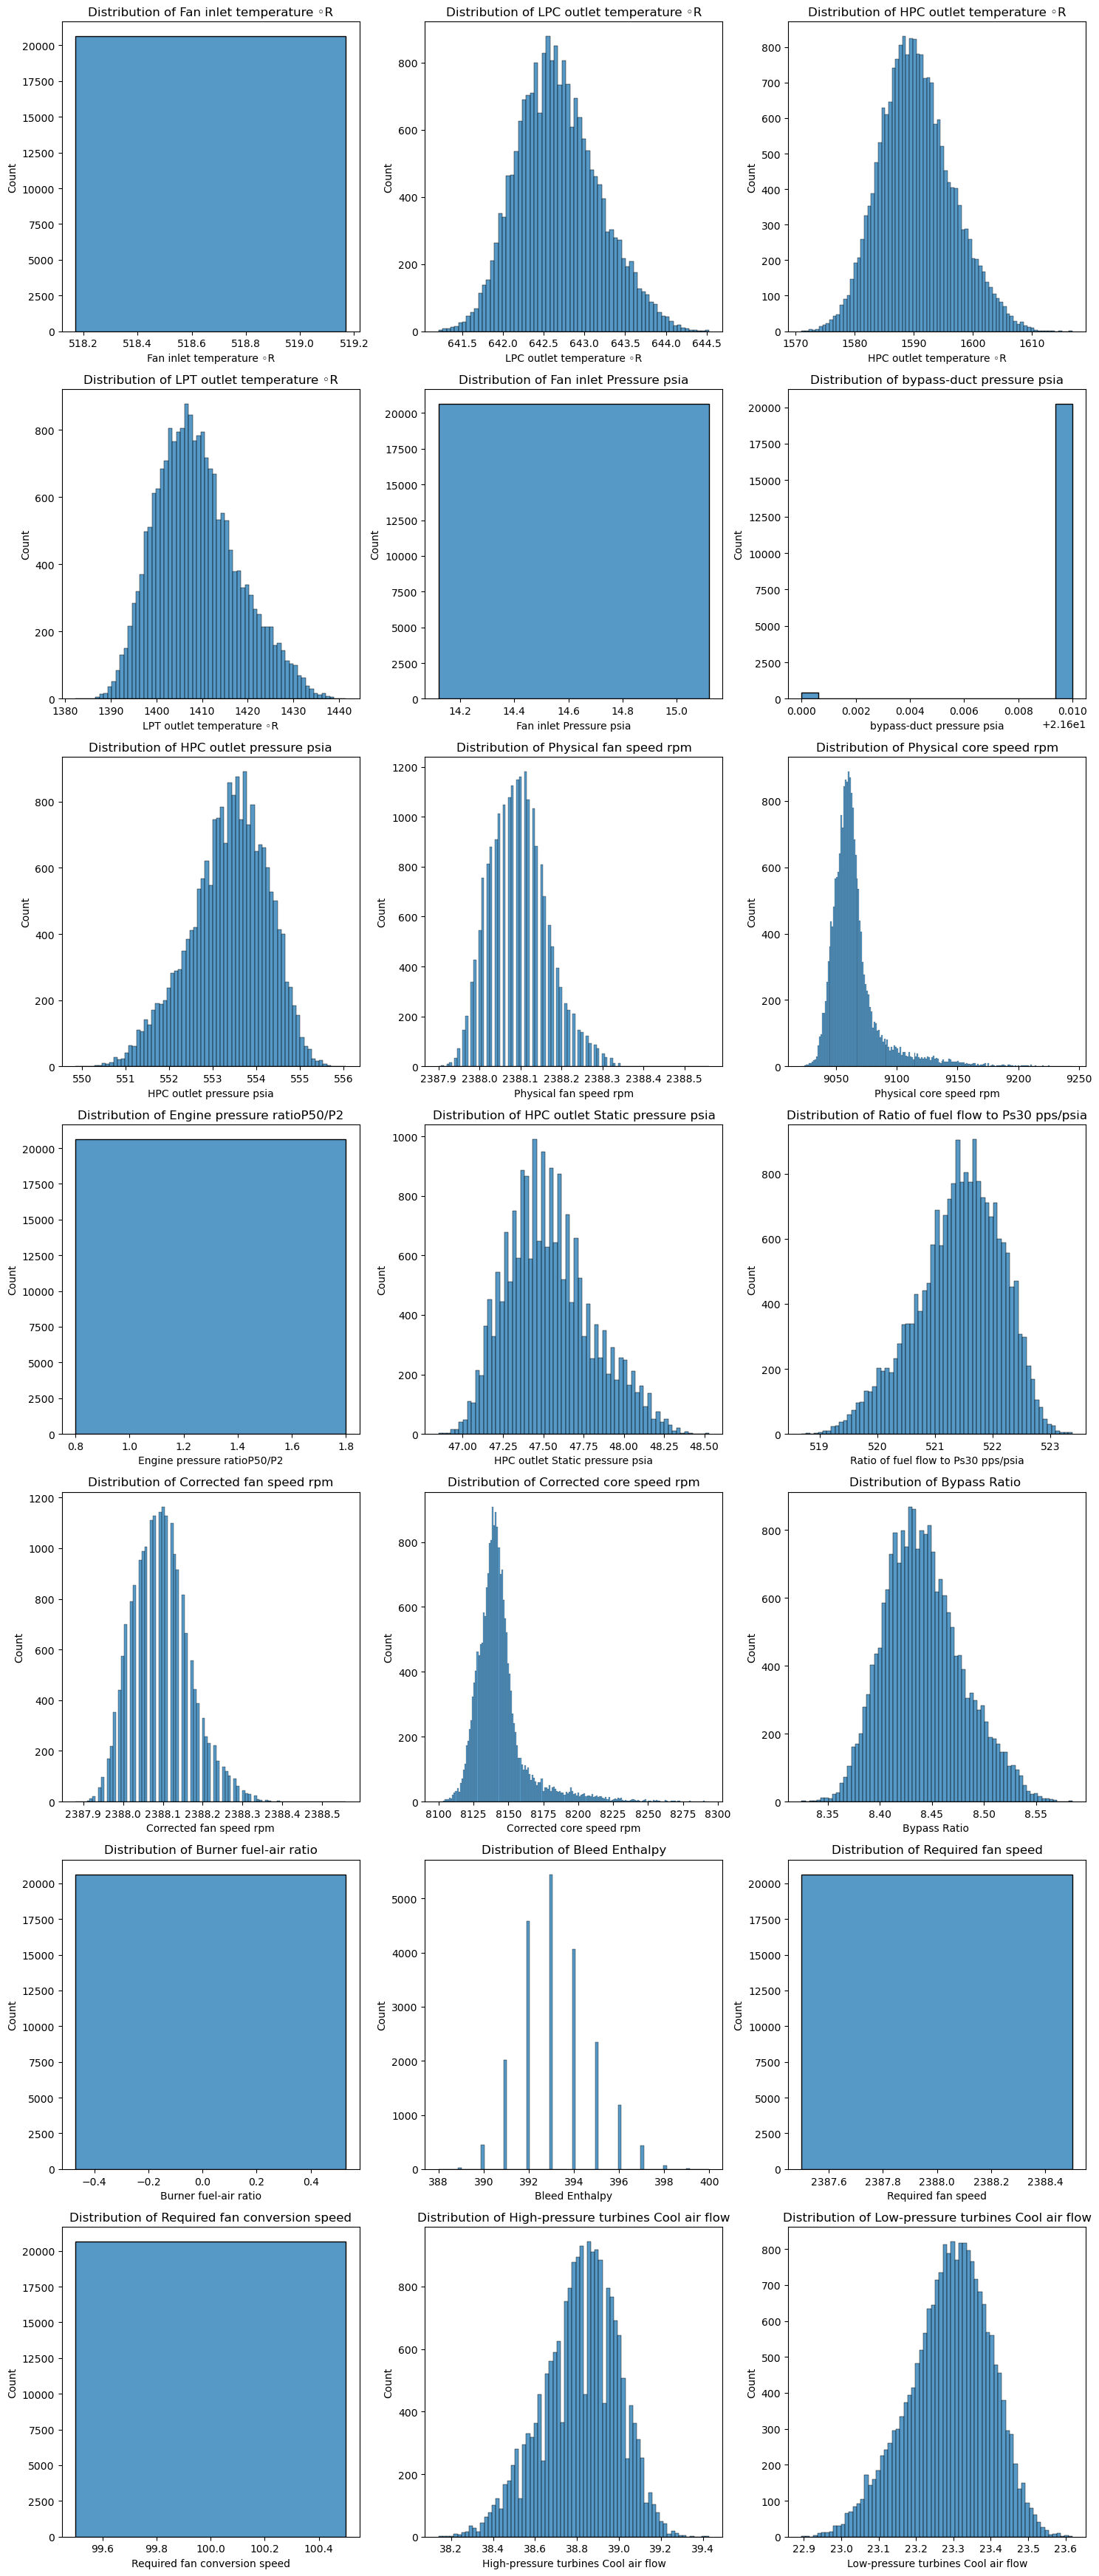

Columns that need normalization: ['bypass-duct pressure psia', 'Physical core speed rpm', 'Corrected core speed rpm']


In [88]:
columns_to_normalize = []

# Determine the number of rows and columns for the subplot grid
num_columns = len([col for col in FD001_data.columns if col in sensor_names])
num_rows = int(np.ceil(num_columns / 3)) #Making columns

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  
axes = axes.flatten()  # Flatten to easily iterate over it

# Loop through each column and create an individual plot (only sensor names)
for i, column in enumerate(FD001_data[sensor_names]):
    if column in sensor_names:
        sns.histplot(data=FD001_data[column], ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        skewness = FD001_data[column].skew()
        print(f'Skewness of {column}: {skewness}')
        
        # Check if the skewness is outside the range of -0.5 to 0.5
        if skewness < -0.5 or skewness > 0.5:
            columns_to_normalize.append(column)

# Hide any unused subplots if there are any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print the columns that need normalization
print(f'Columns that need normalization: {columns_to_normalize}')


The data is a mix of normal and uniform distributions. In the time-series application, I decomposed all the sensor data to determine residuals and generate QQ plots for each sensor feature. The analysis can be found in the timeSeries_explore.ipynb notebook.

I decided not to normalize the 'Physical core speed rpm' and 'Corrected core speed rpm' due to the Augmented Dickey-Fuller (ADF) test scores and the residuals from the time-series decomposition. Despite the skewed distributions of these features, the ADF scores indicated stationarity, and the prediction squared differences showed no significant bias in these features. Additionally, the model performed well within the presence of heteroscedasticity.

Since this data is intended to reflect real-world scenarios, I have decided not to normalize these two features at this time, despite the observed skewness.

This is my first attempt at predicting the remaining useful life (RUL). I will approach this exercise using concepts I am familiar with and deep dive into domain-specific topics. In computer science, we have ways of evaluating the health of computer components and software. Each component of a system has health metrics that indicate stress, load, deterioration, and so on. Although I'm not a domain expert on jet engines, I will assume that the components of a jet fan engine have similar indicators, expressed through meaningful metrics that can be used to understand the health of that component.

Modern jet engines generally operate at a pressure ratio of 40 to 55:1 at sea level (our test case). Generally speaking, a higher overall pressure ratio implies higher efficiency. The downside to higher efficiency, however, is heat. As air travels through the compressor, it reaches temperatures that can cause the deterioration of the compressor blades. This is especially true for the last compressor stage (source: Wikipedia). I will find other components that impact engine performance and outline them at a later time.

The workflow for the jet fan engine is as follows:

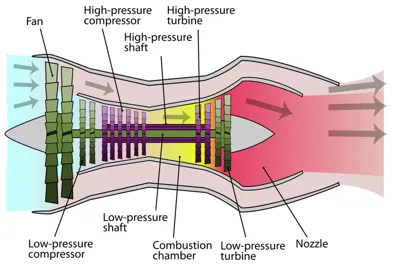


Referring back to my approach of using meaningful metrics to understand component health, the RUL-Based-Prediction.pdf helped me learn the industry-appropriate language: "RUL-Similarity-Hybrid." The RUL-Similarity-Hybrid approach uses both historical data and a model with conditions that indicate failure through calculations. Digesting this information gave me a sense of confidence that, although I was operating outside of my area of expertise, I shared a like-minded methodology for solving this challenge. Additionally, terms like "prognostics estimation" provided a clearer understanding of the concept of remaining useful life (RUL). After reviewing documents in the "Reference Domain Artifacts" directory, I gained insights on how to apply sensor data to industry-recognized formulas for high-pressure compressor health indicators. I have provided those formulas below. 



Gas_Turbine_BestPractices.pdf(page 49)


1. Efficiency Loss:
$$\eta_{\text{loss}} = \eta_0 - \eta$$

2. Current Efficiency:
$$\eta = \frac{T_{\text{outlet\_ideal}} - T_{\text{inlet}}}{T_{\text{outlet\_actual}} - T_{\text{inlet}}}$$

3. Ideal Outlet Temperature:
$$T_{\text{outlet\_ideal}} = T_{\text{inlet}} \times \left( \frac{P_{\text{outlet}}}{P_{\text{inlet}}} \right)^{\frac{\gamma - 1}{\gamma}}$$

4. Flow Loss:
$$\text{Flow Loss} = \dot{m}_0 - \dot{m}$$

5. Corrected Flow:
$$\dot{m}_{\text{corrected}} = \sqrt{\frac{T_{\text{inlet}}}{T_{\text{std}}}} \times \frac{P_{\text{std}}}{P_{\text{inlet}}}$$

6. Stall Margin
$$\text{Stall Margin} = a \times \eta_{\text{loss}} + b \times \text{Flow Loss} + c$$

I will use these calculations as features for my model.



In [89]:
# Defining the HPC threshold failure margin ##Provided by Damage Propagation Modeling.pdf
HPC_stall_margin_threshold = 0.15 

# Normal operating conditions or baseline efficiency and flow values (#provide reference Juba)
eta_0 = 0.40  # baseline efficiency (n_0) when the engine was new. This is needed to establish a reference point for normal working conditions.
baseline_flow = +0.08  # baseline flow ##Provided by Damage Propagation Modeling.pdf

# Constants for standard conditions(conditions at sea level)  #Google
T_std = 518.67  # Standard temperature in Rankine
P_std = 14.70  # Standard pressure in psia

# Stall Margin calculation Coefficients Derived from the table of Wear Values (Damage Propagation Modeling)
a = -3.81 # Coefficient for efficiency loss
b = +2.57  # Coefficient for flow loss
c = 1.0    # Example intercept

#Gathering and setting data for calculations mentioned int he formula area. 
T_inlet = FD001_data['Fan inlet temperature ◦R']
P_inlet = FD001_data['Fan inlet Pressure psia']
T_outlet_actual = FD001_data['HPC outlet temperature ◦R']
P_outlet = FD001_data['HPC outlet pressure psia']

#used to calculate how much the temperature would rise due to compression process. 1.4 is standard for air under these conditions for turbine engines. 
gamma = 1.4 

# Pressure ratio across HPC
PR = P_outlet / P_inlet

# Calculate ideal outlet temperature for isentropic process
T_outlet_ideal = T_inlet * (PR ** ((gamma - 1) / gamma))

# Current efficiency calculation
eta = (T_outlet_ideal - T_inlet) / (T_outlet_actual - T_inlet)

# Efficiency Loss calculation
efficiency_loss = eta_0 - eta
FD001_data['efficiency_loss'] = efficiency_loss

# Corrected flow calculation
corrected_flow = np.sqrt(T_inlet / T_std) * (P_std / P_inlet)

# Flow Loss calculation
flow_loss = baseline_flow - corrected_flow
FD001_data['flow_loss'] = flow_loss

# Stall Margin calculation
stall_margin = a * efficiency_loss + b * flow_loss + c
FD001_data['stall_margin'] = stall_margin

# Define the nominal stall margin for comparison
nominal_stall_margin = FD001_data['stall_margin'].max()

# Calculate the threshold for failure
stall_margin_failure_threshold = nominal_stall_margin * (1 - HPC_stall_margin_threshold)

# Check if stall margin falls below the threshold and flag it
FD001_data['HPC_failure'] = FD001_data['stall_margin'] < stall_margin_failure_threshold

# Display the rows where the failure condition is met
failures = FD001_data[FD001_data['HPC_failure']]


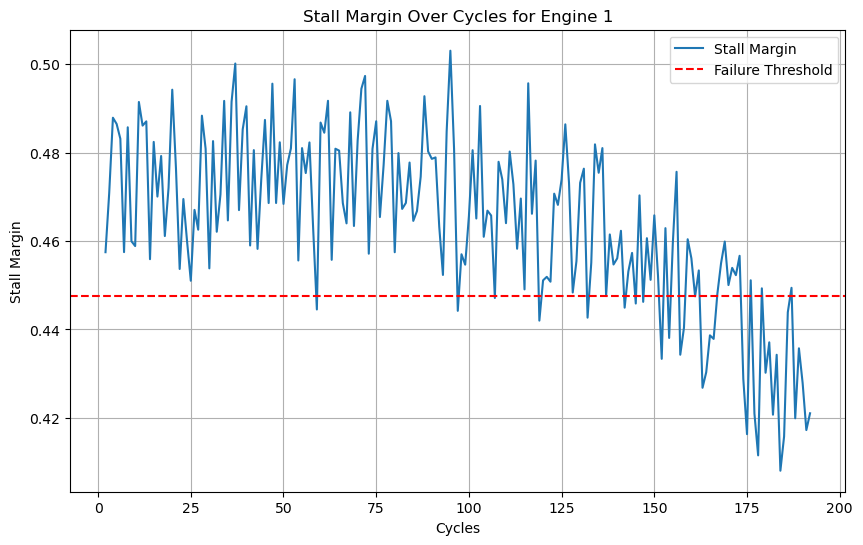

In [90]:
engine_id = 1
engine_data = FD001_data[FD001_data['Engine'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
plt.xlabel('Cycles')
plt.ylabel('Stall Margin')
plt.legend()
plt.grid(True)
plt.show()

#print(stall_margin)




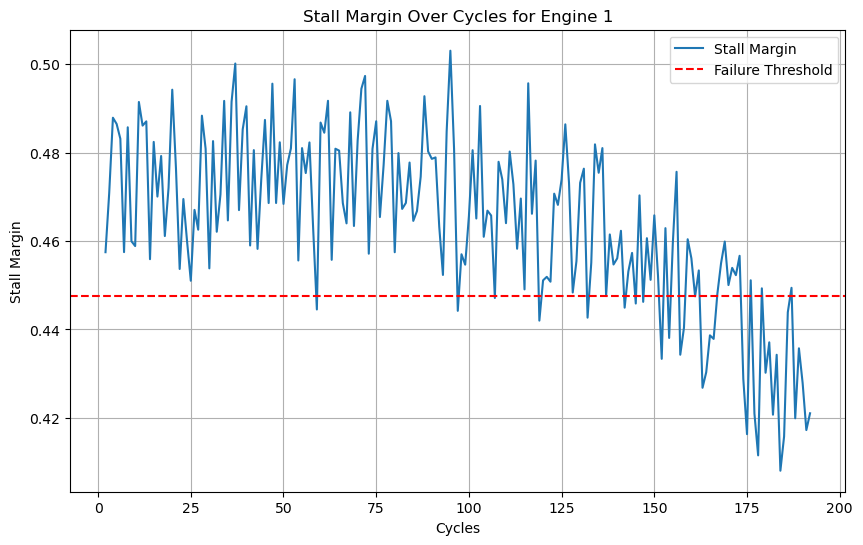

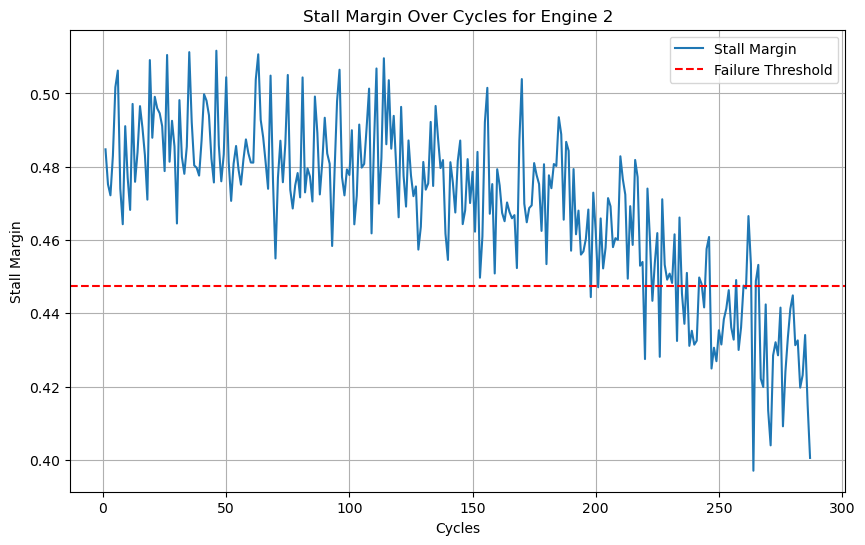

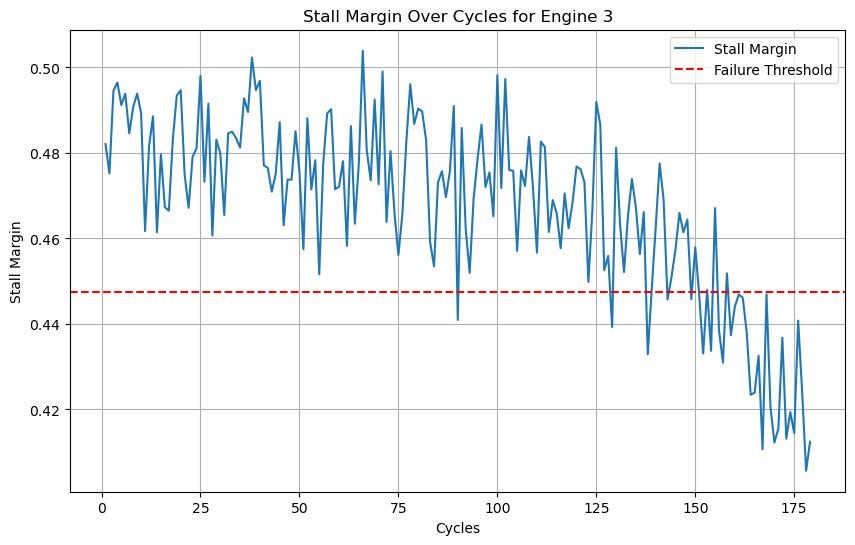

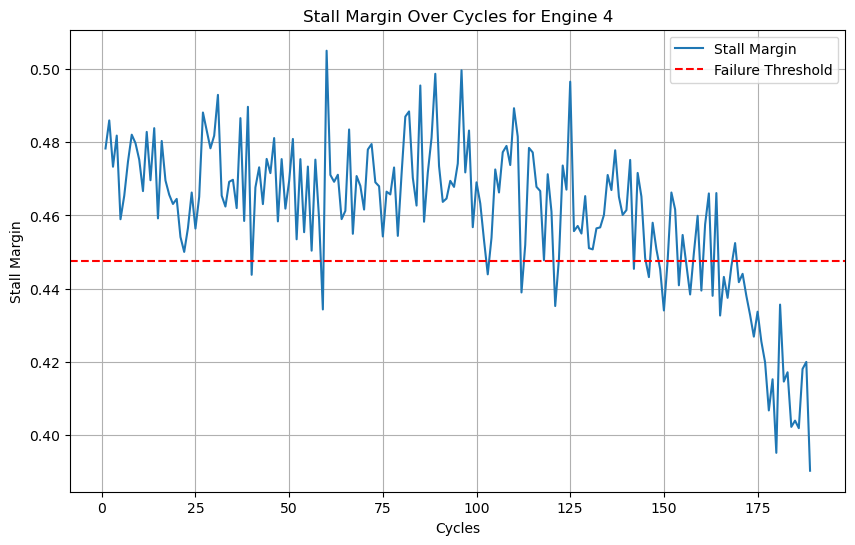

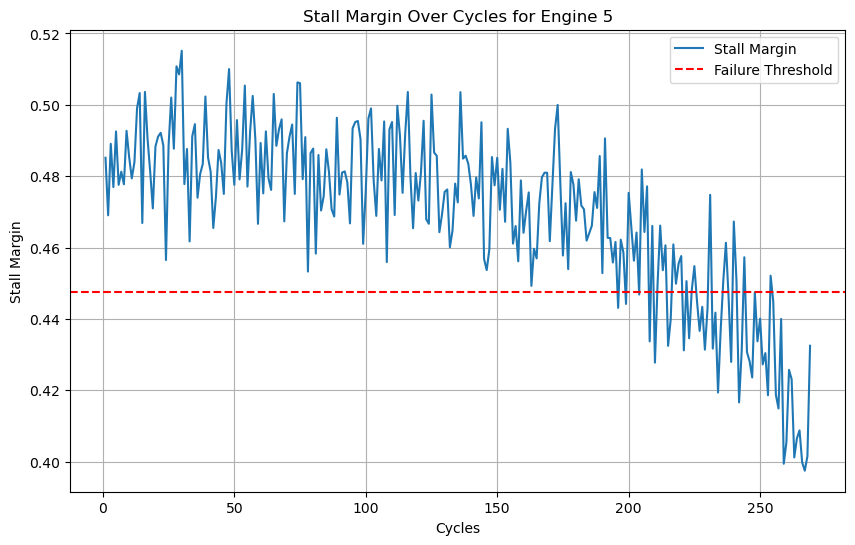

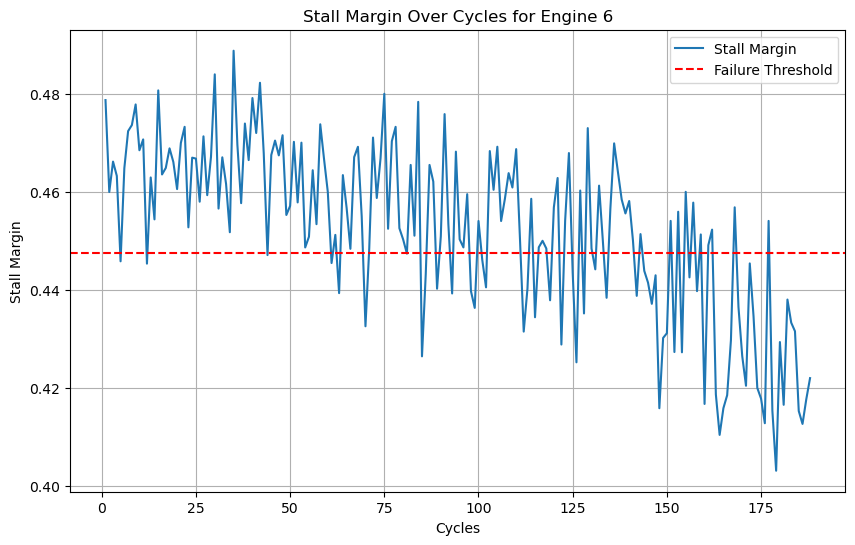

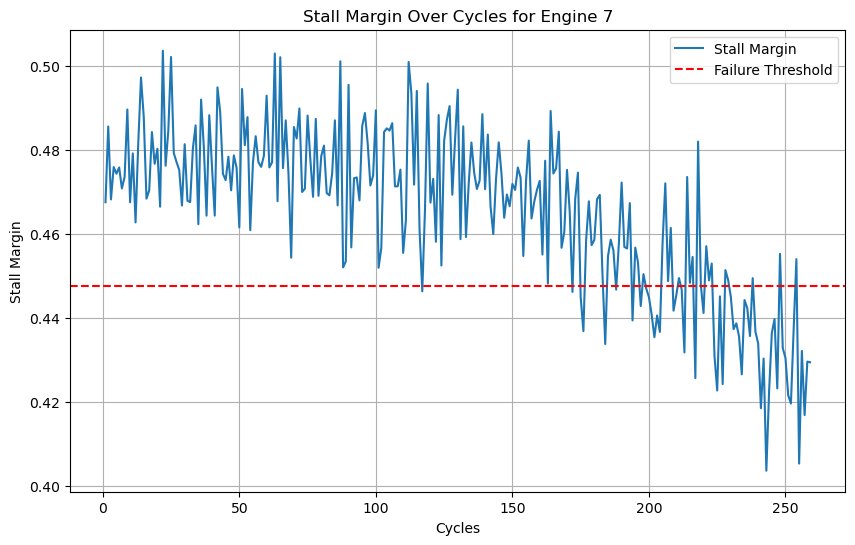

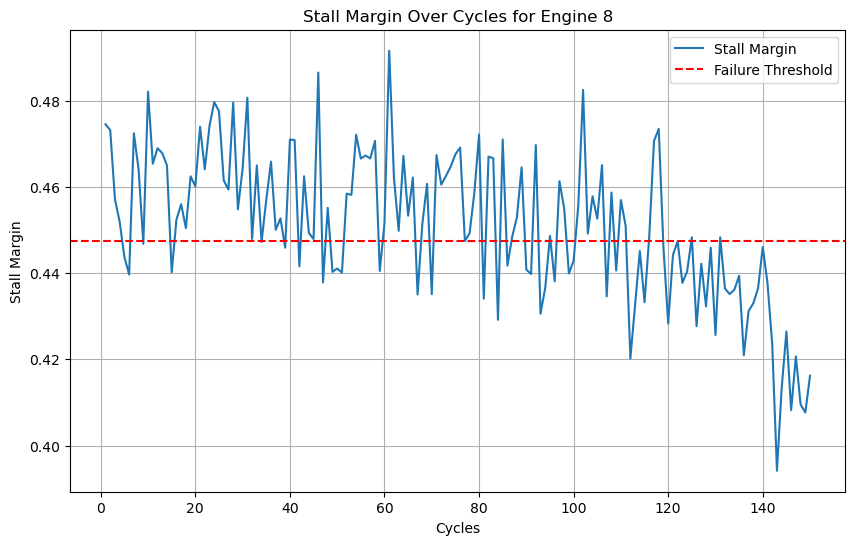

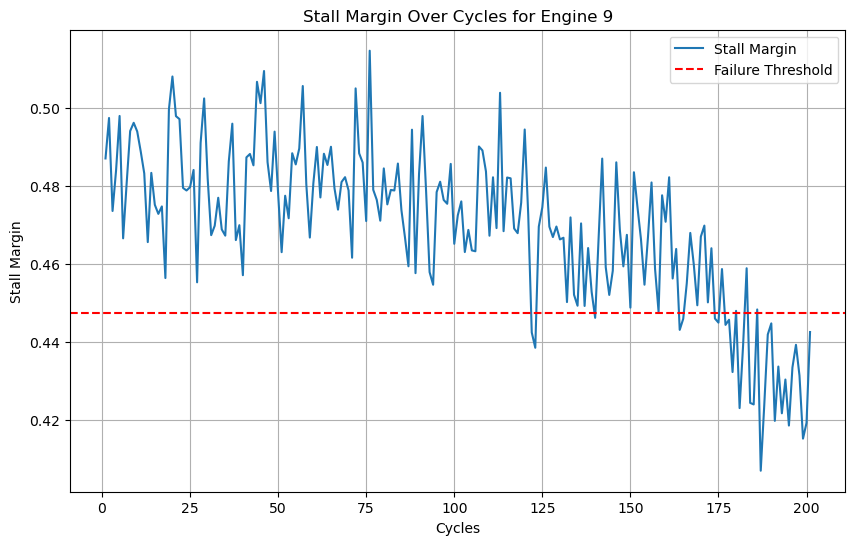

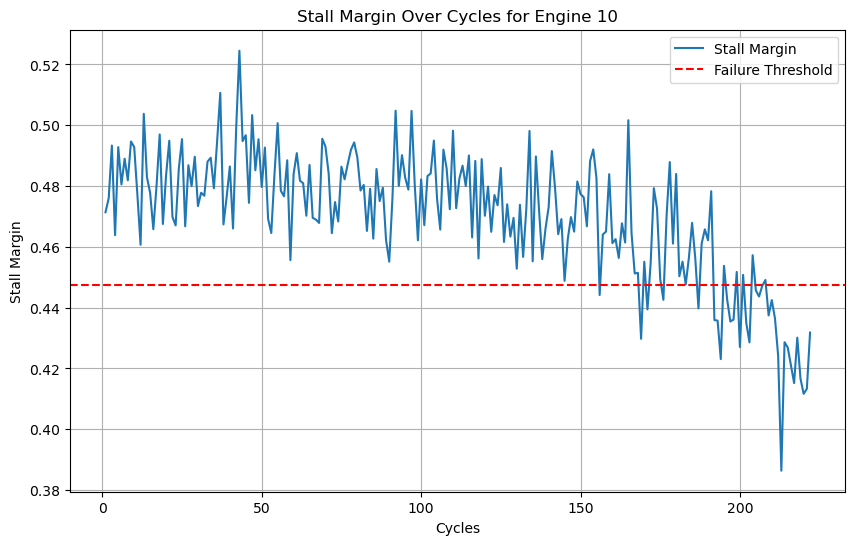

In [91]:


# Function to plot stall margin over cycles for each engine
def plot_stall_margin(engine_ids, df, failure_threshold):
    for engine_id in engine_ids:
        engine_data = df[df['Engine'] == engine_id]

        plt.figure(figsize=(10, 6))
        plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
        plt.axhline(failure_threshold, color='red', linestyle='--', label='Failure Threshold')
        plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
        plt.xlabel('Cycles')
        plt.ylabel('Stall Margin')
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming 'Engine' column identifies the engine number and 'Cycles' column identifies the cycle count
engine_ids = FD001_data['Engine'].unique()[:10]  # Select the first 10 engines

# Plot stall margin for the first 10 engines
plot_stall_margin(engine_ids, FD001_data, stall_margin_failure_threshold)


In [92]:
FD001_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

These are the wear ranges defined in the Damage Propagation Modeling.pdf
As you can see, HPT efficiency is listed here but not HCP. One is for the H-turbine and the other is for the H-compressor. I'm inferring that these two components have a high degree of correlation based on their function. 

| Parameter         | Initial Wear (%) | Wear 3000 Cycles (%) | Wear 6000 Cycles (%) |
|-------------------|------------------|----------------------|----------------------|
| Fan Efficiency    | -0.18            | -1.5                 | -2.85                |
| Fan Flow          | -0.26            | -2.04                | -3.65                |
| LPC Efficiency    | -0.62            | -1.46                | -2.61                |
| LPC Flow          | -1.01            | -2.08                | -4.00                |
| HPT Efficiency    | -0.48            | -2.63                | -3.81                |
| HPT Flow          | +0.08            | +1.76                | +2.57                |
| LPT Efficiency    | -0.10            | -0.54                | -1.08                |
| LPT Flow          | +0.08            | +0.26                | +0.42                |


In [93]:
#adding wear manifest ranges as features

#Initial Wear
FD001_data['Baseline_Efficiency'] =0.0
FD001_data['Initial_Wear_HPT_Efficiency'] = -0.48
FD001_data['Initial_Wear_HPT_Flow'] = +0.08

#Wear 3000 Cycles
FD001_data['3000_Wear_HPT_Efficiency'] = -2.63
FD001_data['3000_Wear_HPT_Flow'] = +1.76

#Wear 6000 Cycles
FD001_data['6000_Wear_HPT_Efficiency'] = -3.81
FD001_data['6000_Wear_HPT_Flow'] = +2.57




In [94]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
y = FD001_data['stall_margin']

scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [95]:
lin_model = LinearRegression().fit(X_scale,y)
preds = lin_model.predict(X_scale)
absMean = mean_absolute_error(y,preds)
print(absMean)
#Calculate R2 score
r2_poly_lin = r2_score(y,preds)
print(f'r2 score is:{r2_poly_lin}')

0.013761562323998248
r2 score is:0.3226818237748451


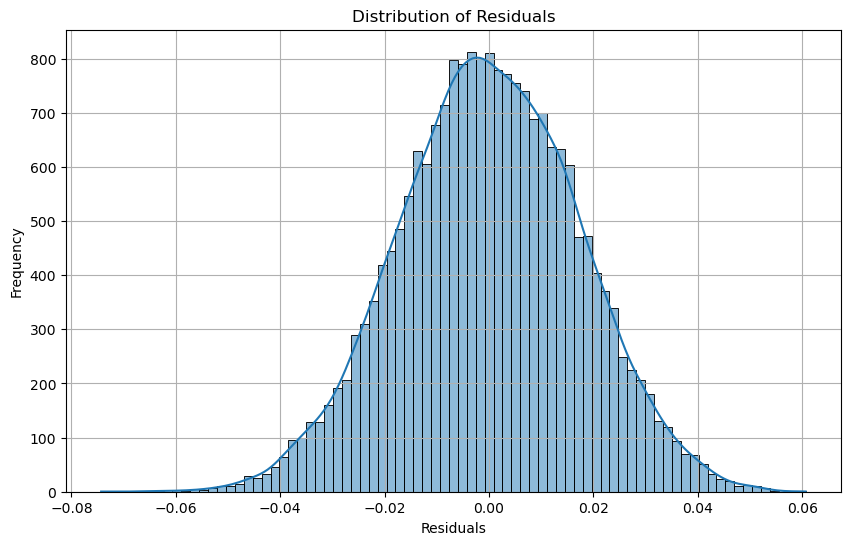

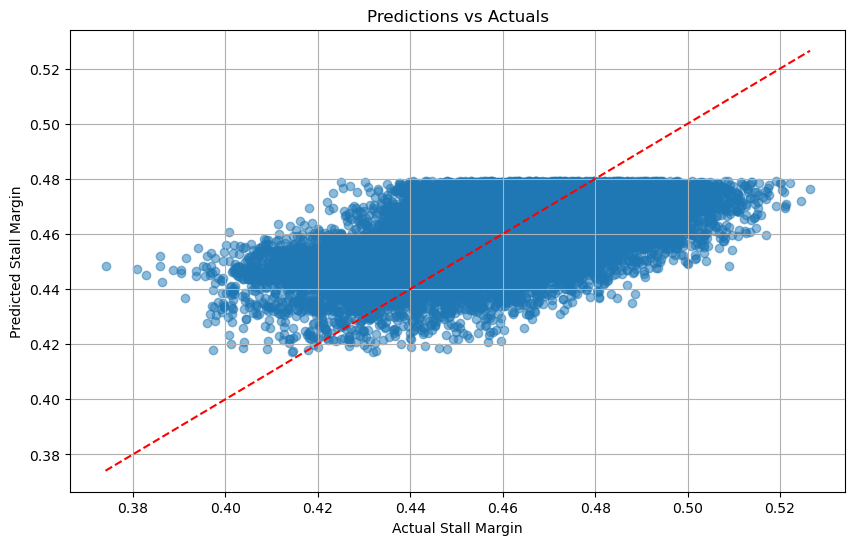

In [96]:
residuals = y - preds

# Plotting Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting Predictions vs. Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y, preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Identity line
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.grid(True)
plt.show()

In [97]:
poly_pipe = Pipeline([('poly',PolynomialFeatures()),('lin',LinearRegression())]).fit(X_scale,y)


In [98]:
params ={
    'poly__degree':[2,3],
    'lin__fit_intercept': [True, False]
}

In [99]:
poly_grid = GridSearchCV(poly_pipe,param_grid=params,n_jobs=-1,cv=5).fit(X_scale,y)
best_params = poly_grid.best_params_
best_score = poly_grid.best_score_

In [100]:
print(best_params,best_score)

{'lin__fit_intercept': False, 'poly__degree': 3} 0.3184821782853298


Mean Absolute Error (Polynomial): 0.013622234793790869
r2 score is:0.3358903455303325


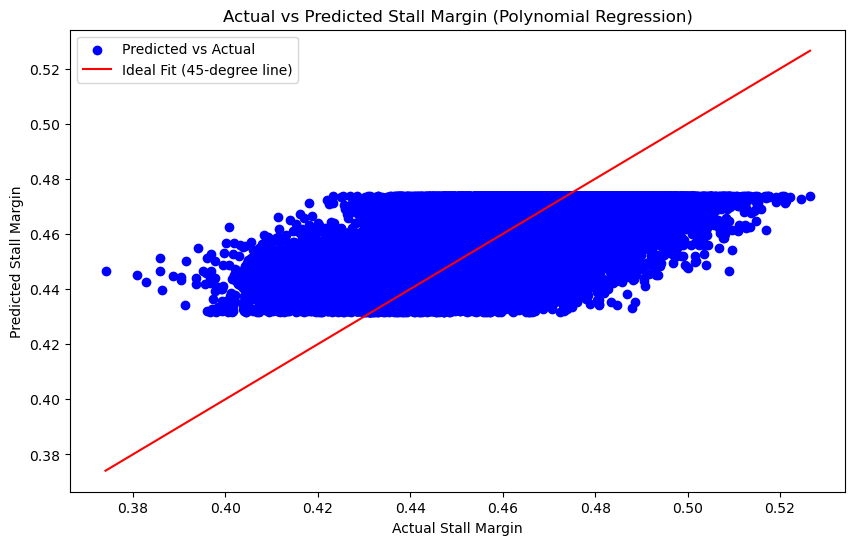

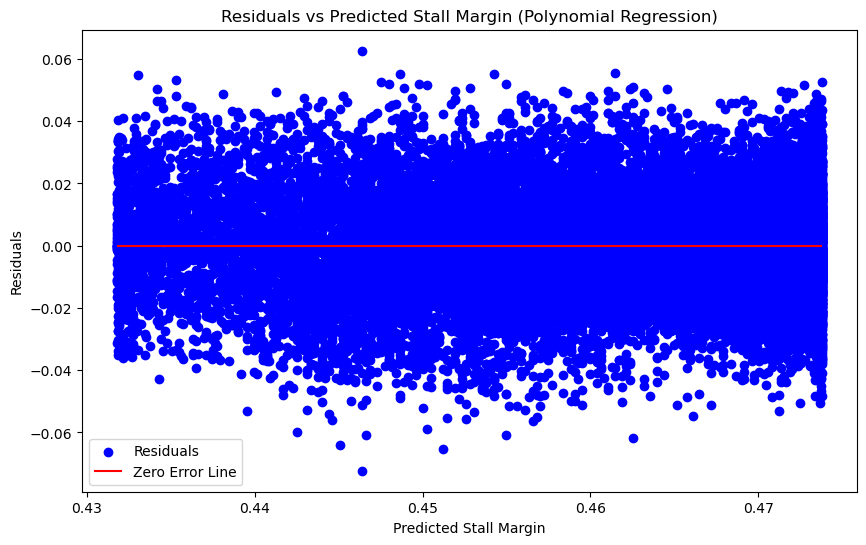

In [101]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
y = FD001_data['stall_margin']

# Create polynomial features
poly = PolynomialFeatures(degree=3,include_bias=False)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
poly_model = LinearRegression().fit(X_poly, y)

# Predict the stall margin using the model
y_poly_pred = poly_model.predict(X_poly)

# Calculate the mean absolute error
mae_poly = mean_absolute_error(y, y_poly_pred)
print(f'Mean Absolute Error (Polynomial): {mae_poly}')

#Calculate R2 score
r2_poly = r2_score(y,y_poly_pred)
print(f'r2 score is:{r2_poly}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_poly_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Fit (45-degree line)')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.title('Actual vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

# Residuals plot
residuals = y - y_poly_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_poly_pred, residuals, color='blue', label='Residuals')
plt.hlines(y=0, xmin=min(y_poly_pred), xmax=max(y_poly_pred), color='red', label='Zero Error Line')
plt.xlabel('Predicted Stall Margin')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

My model is capturing data across the entire fleet so my actual vs. prediction plots have too much data and show no trend. Instead, I need to model according to single engine or the aggregate of the fleet.(I have to research how to do this). But so you can see my thought process I'll do my best to make better sense of the data. 

r2 score is:0.5106062218596366


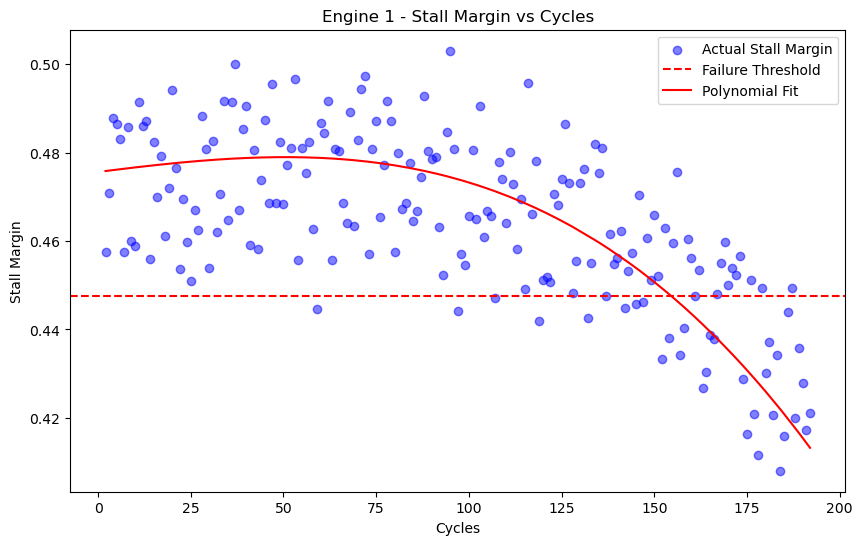

r2 score is:0.6879356690971414


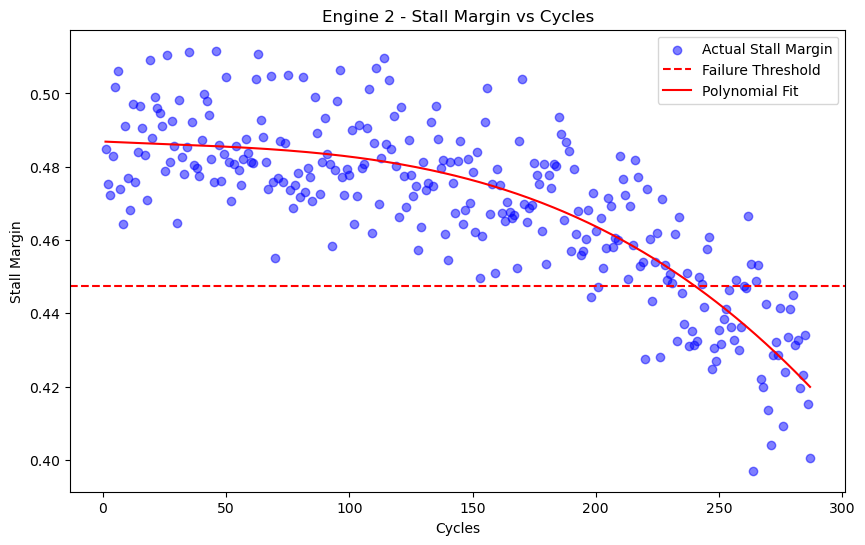

r2 score is:0.6819709408325737


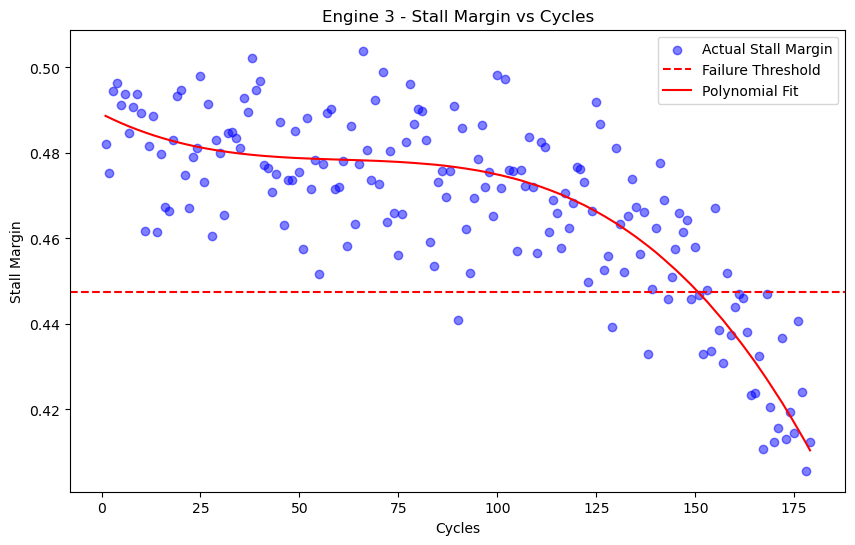

r2 score is:0.632087618458103


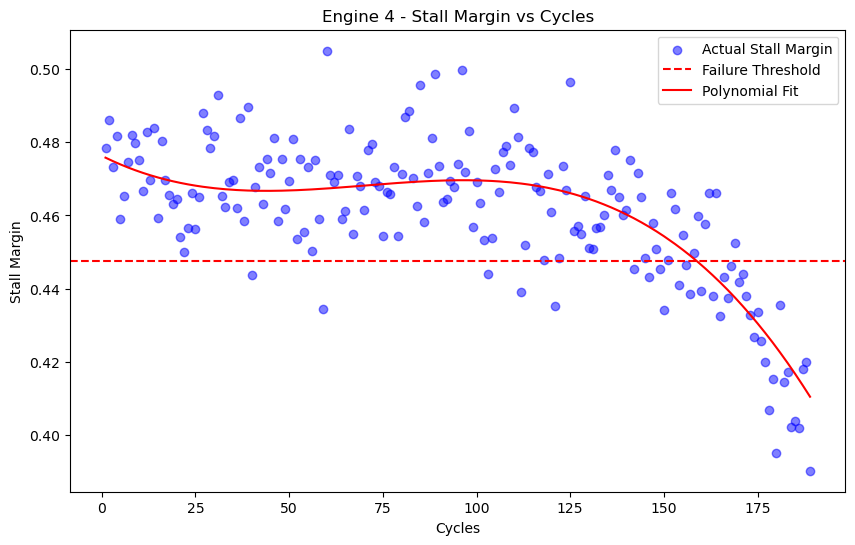

r2 score is:0.7128003695879896


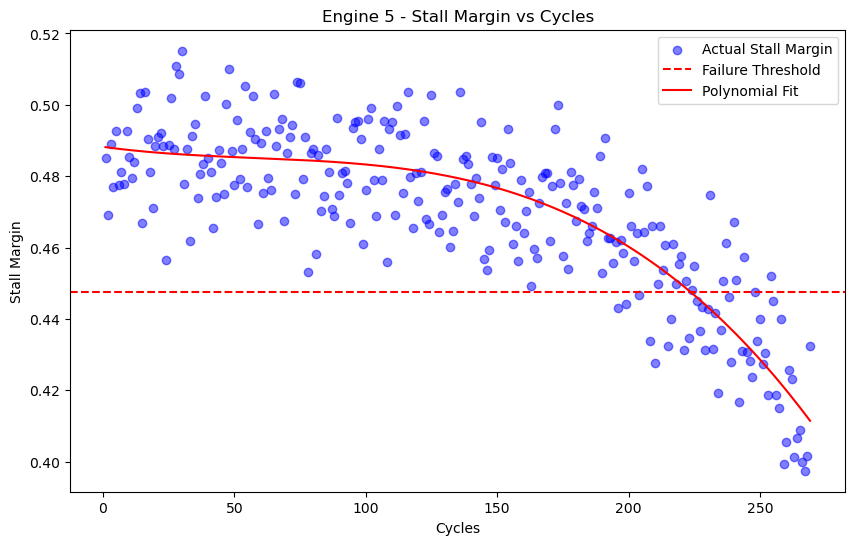

r2 score is:0.49290512034923706


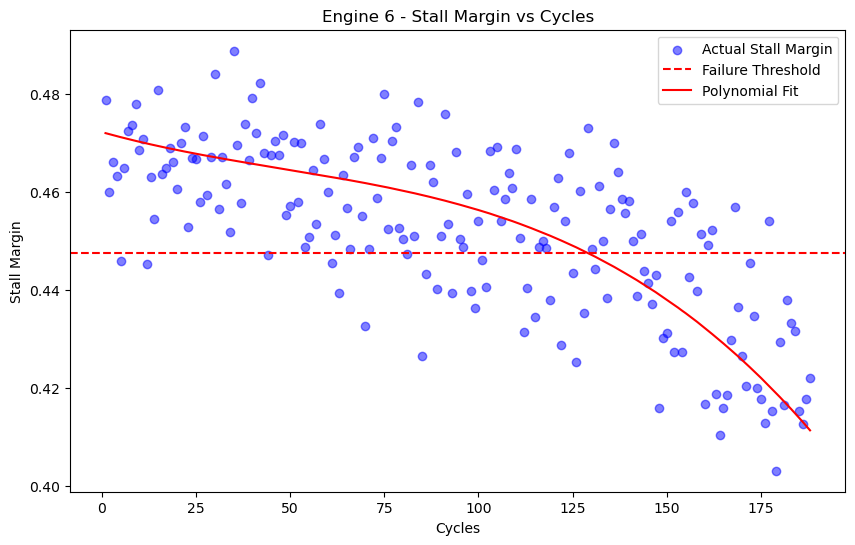

r2 score is:0.6463858135576532


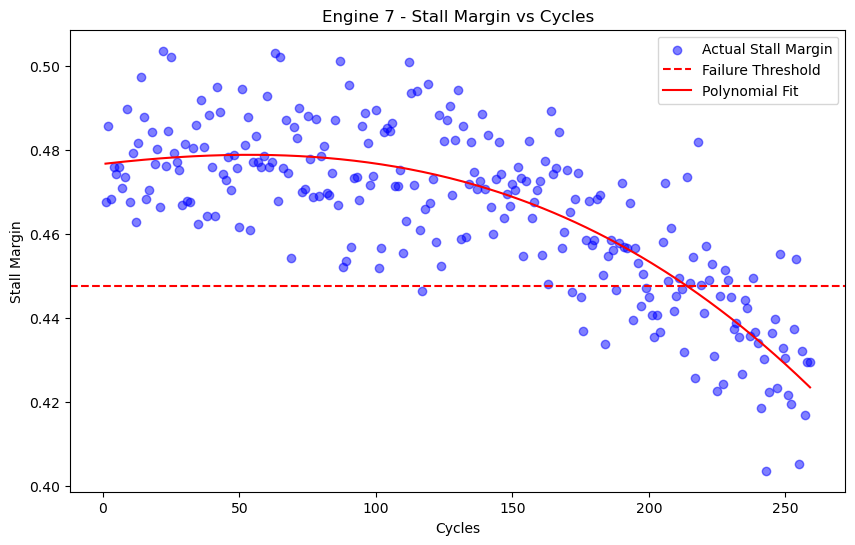

r2 score is:0.3755384778232531


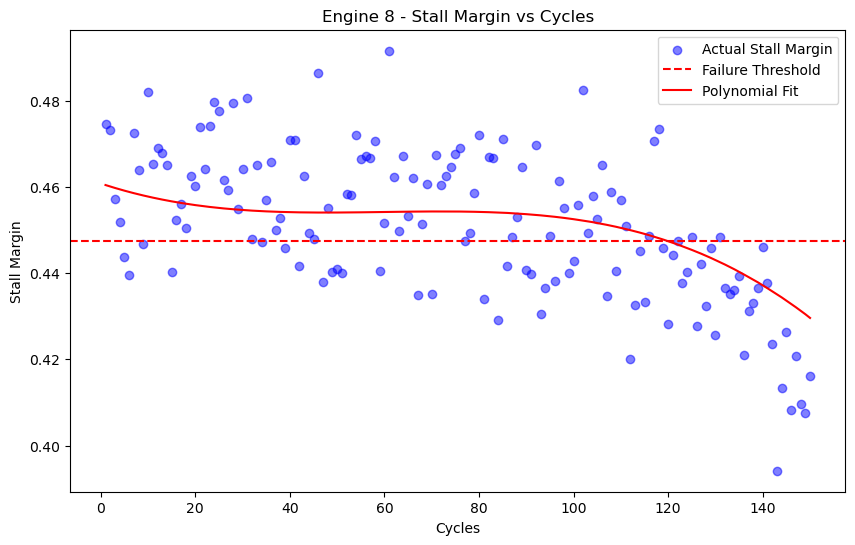

r2 score is:0.4772692021210606


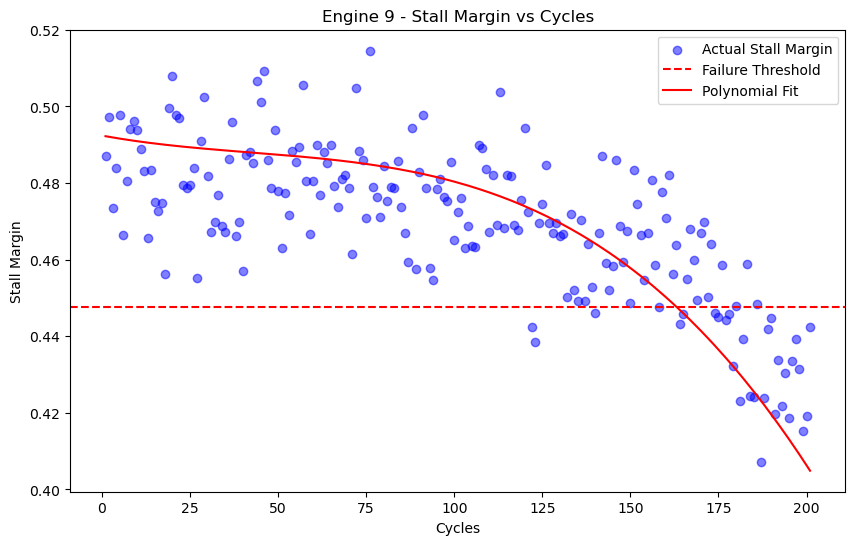

r2 score is:0.6167657389146828


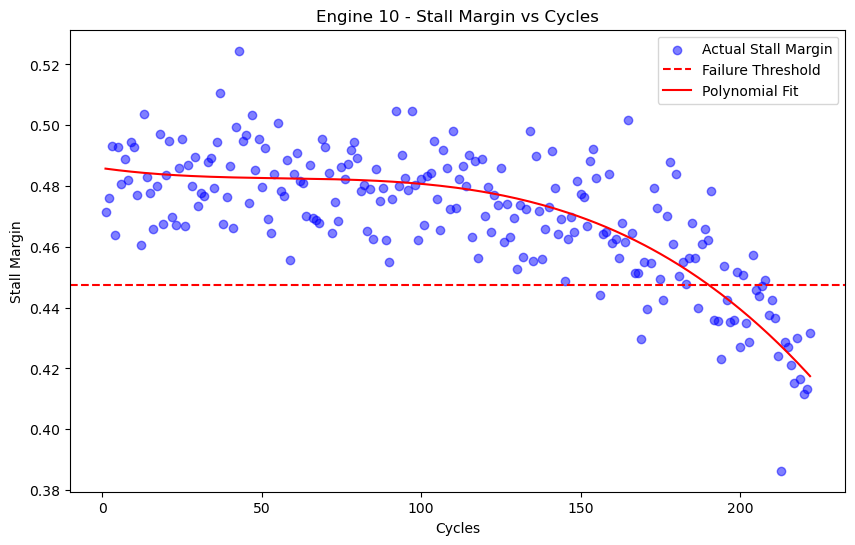

r2 score is:0.6550020900923457


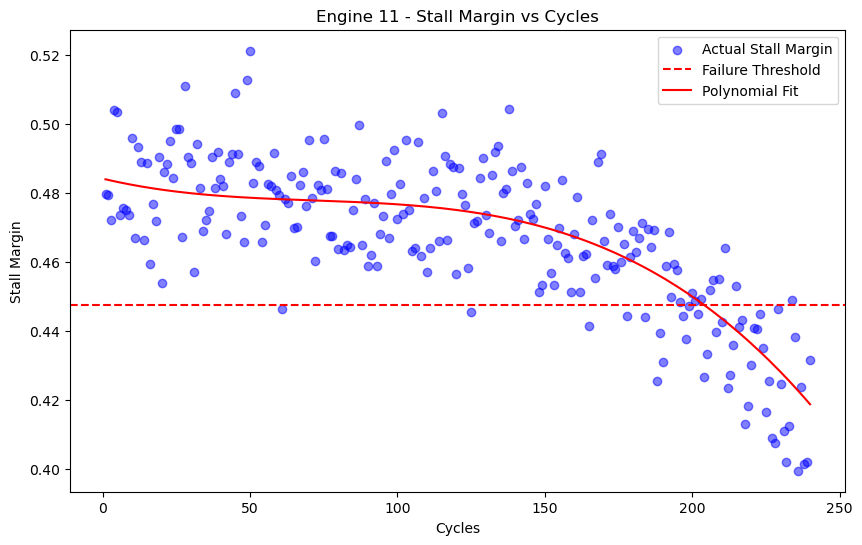

r2 score is:0.22882411721718487


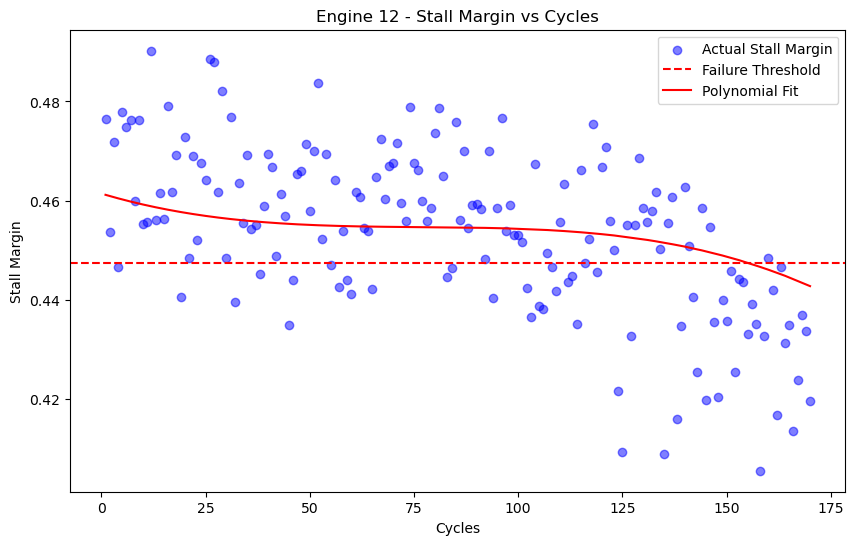

r2 score is:0.5853465204806654


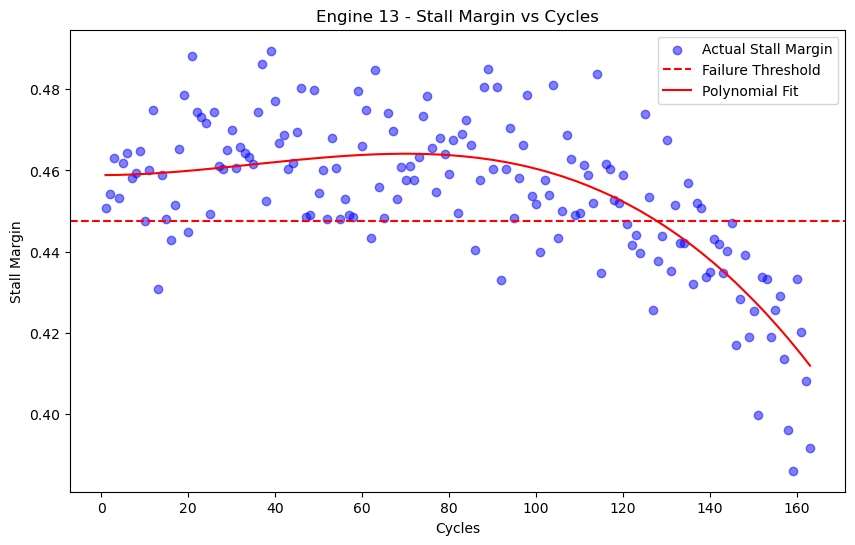

r2 score is:0.4857349625879622


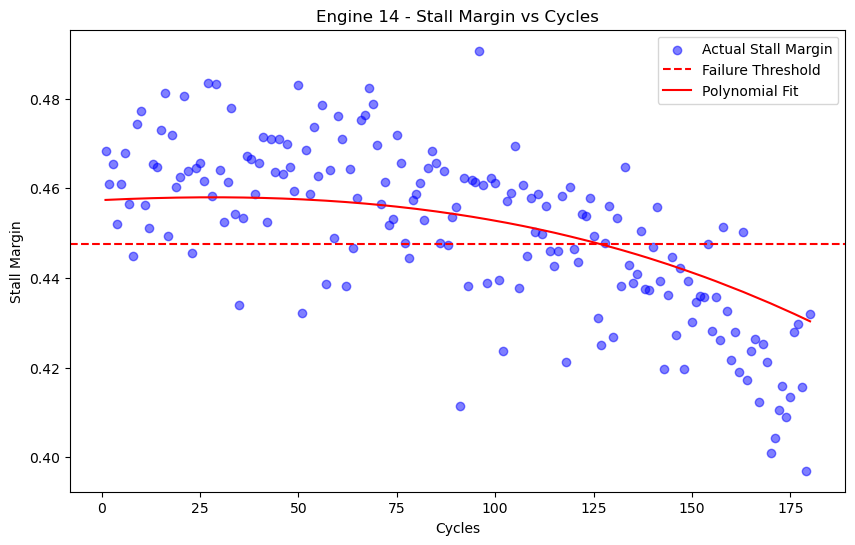

r2 score is:0.6702061392225045


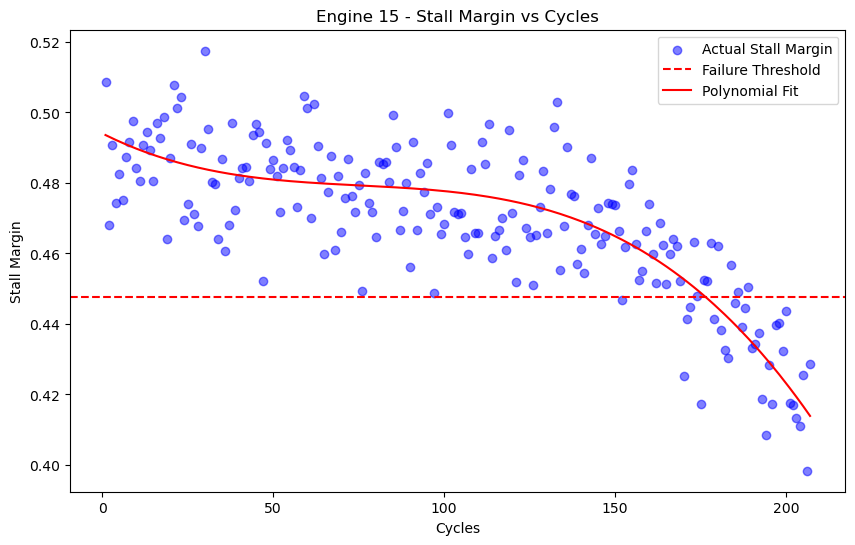

r2 score is:0.2643609601803458


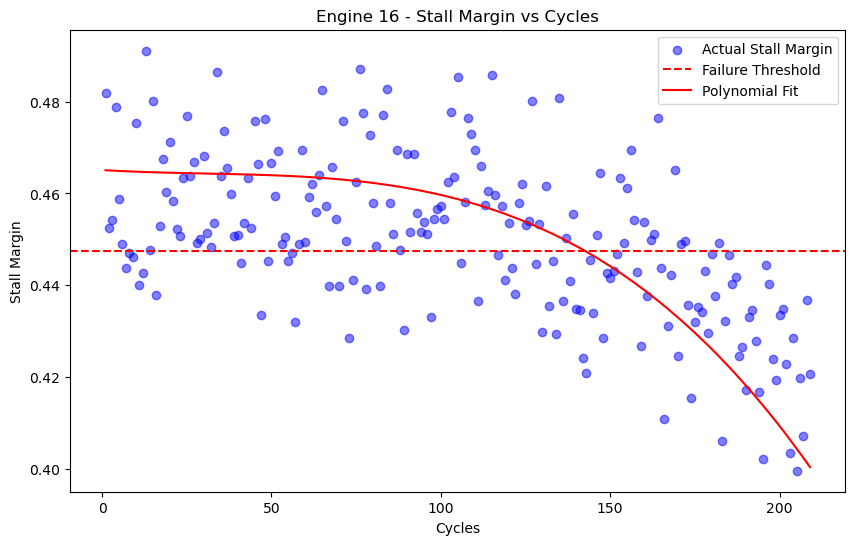

r2 score is:0.6402325718700033


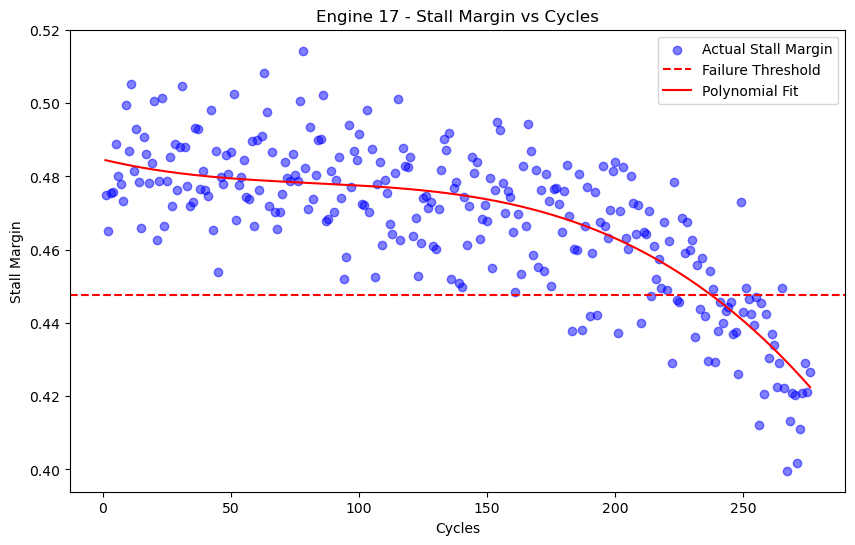

r2 score is:0.6760238811667874


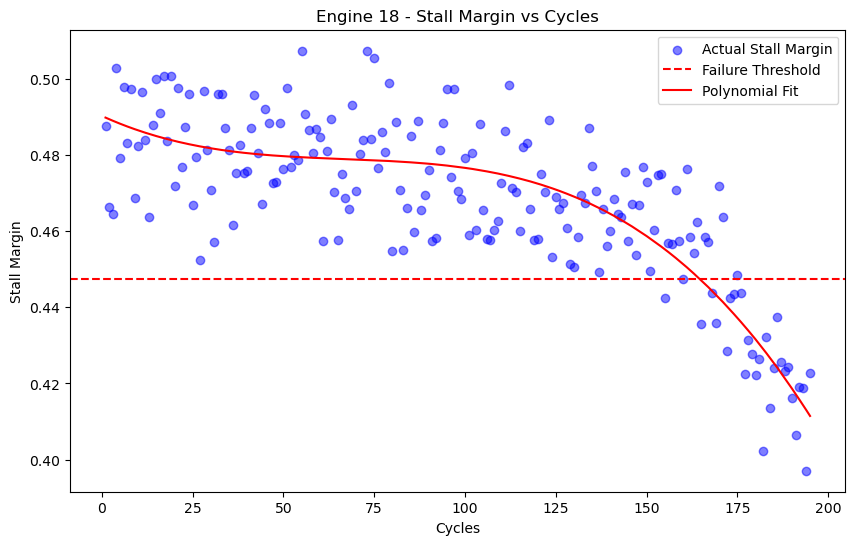

r2 score is:0.48167869277797215


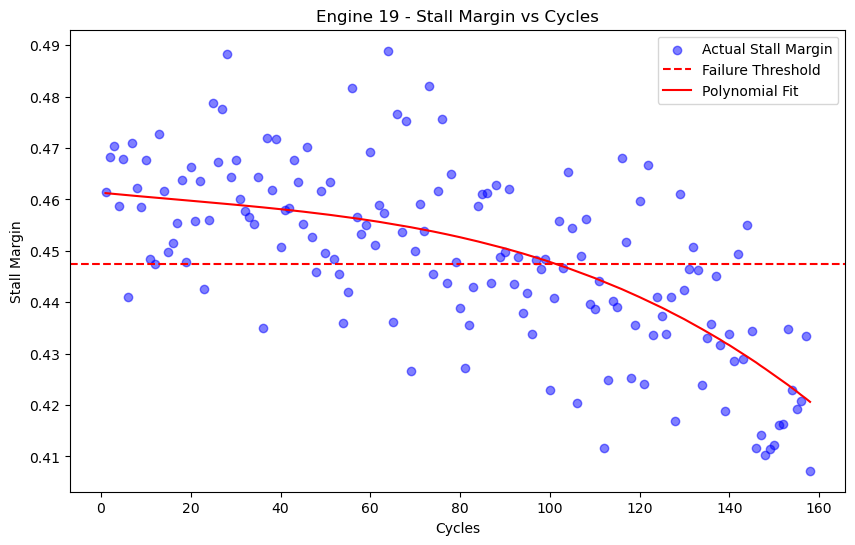

r2 score is:0.5363935194193484


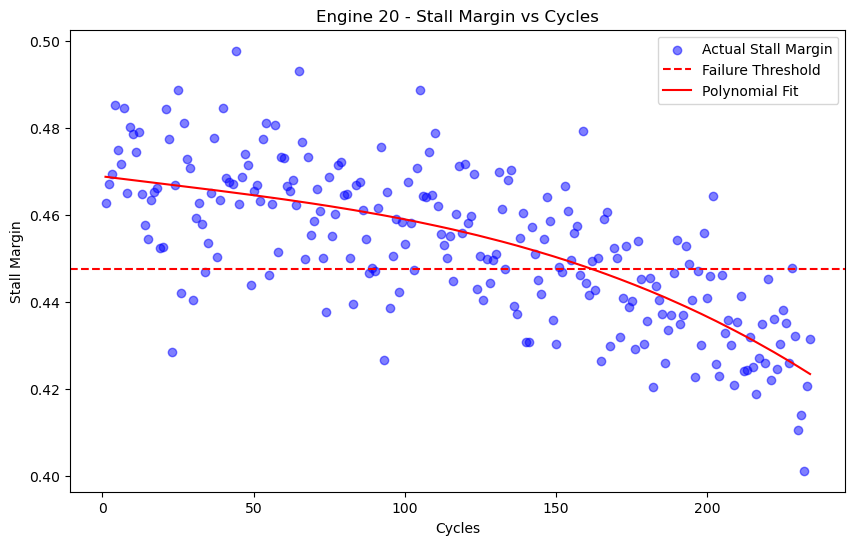

r2 score is:0.500682961995768


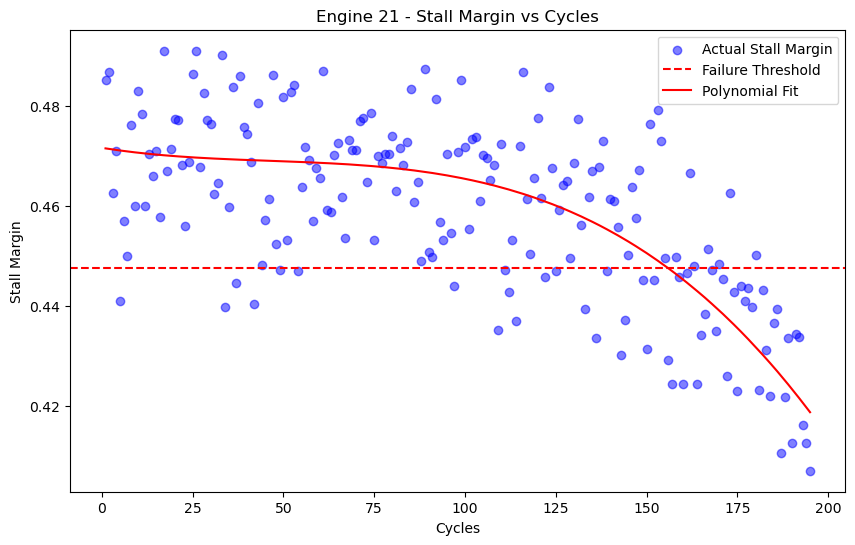

r2 score is:0.3201753029406659


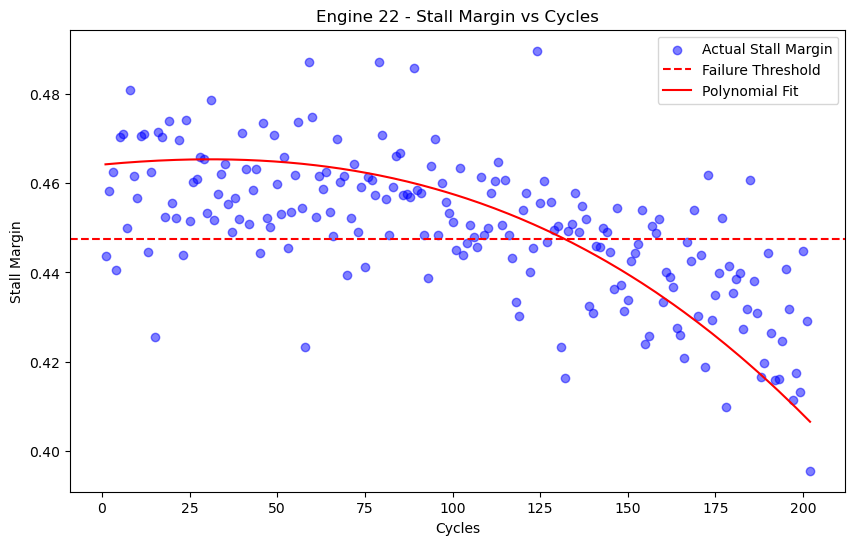

r2 score is:0.33848390154015207


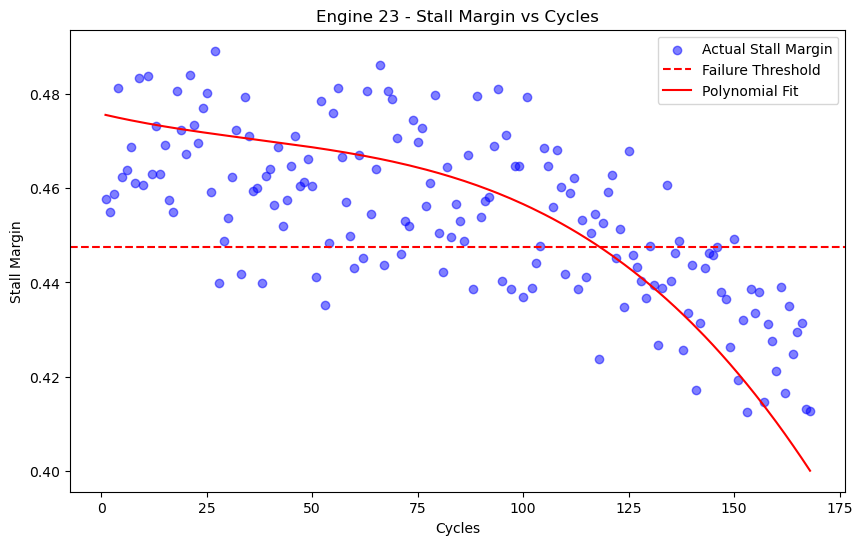

r2 score is:0.6078018822645777


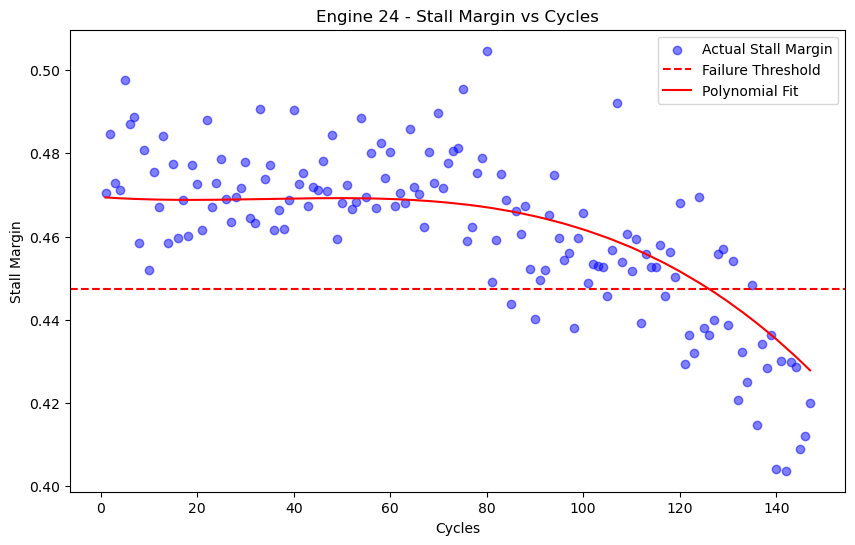

r2 score is:0.5458126621817269


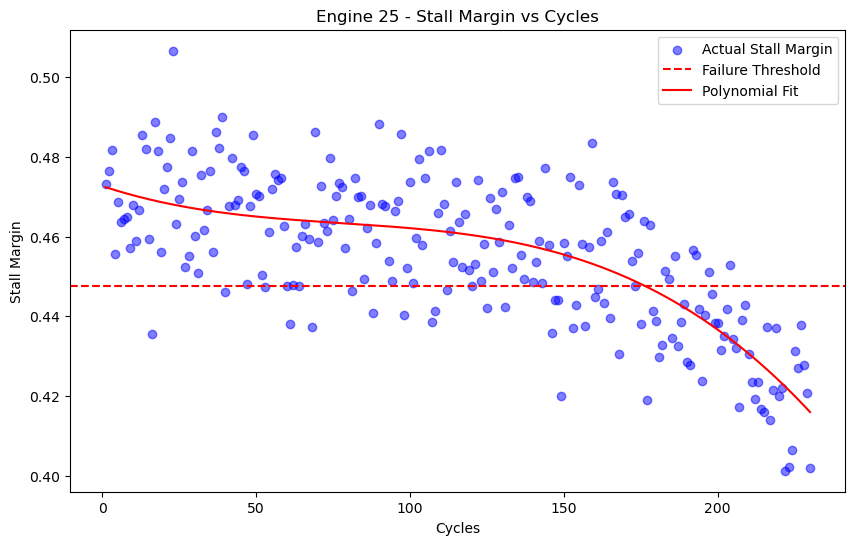

r2 score is:0.49781836840039184


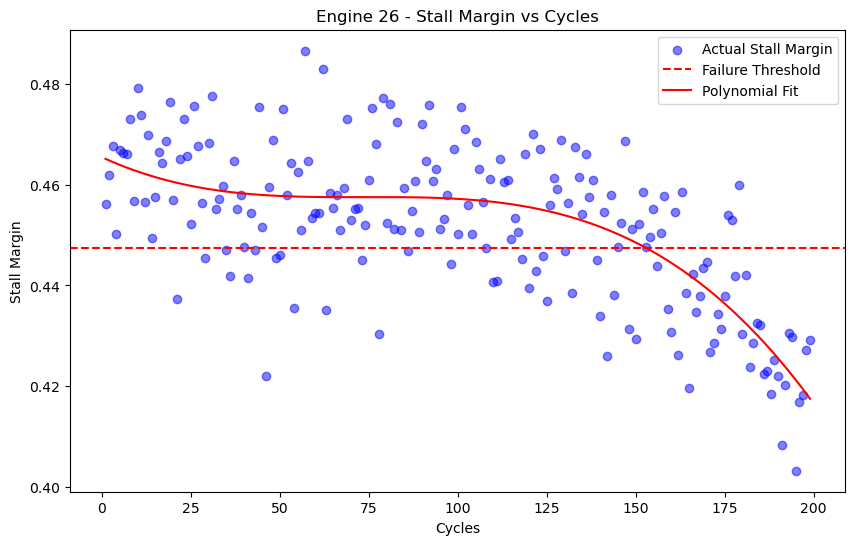

r2 score is:0.5806741765530883


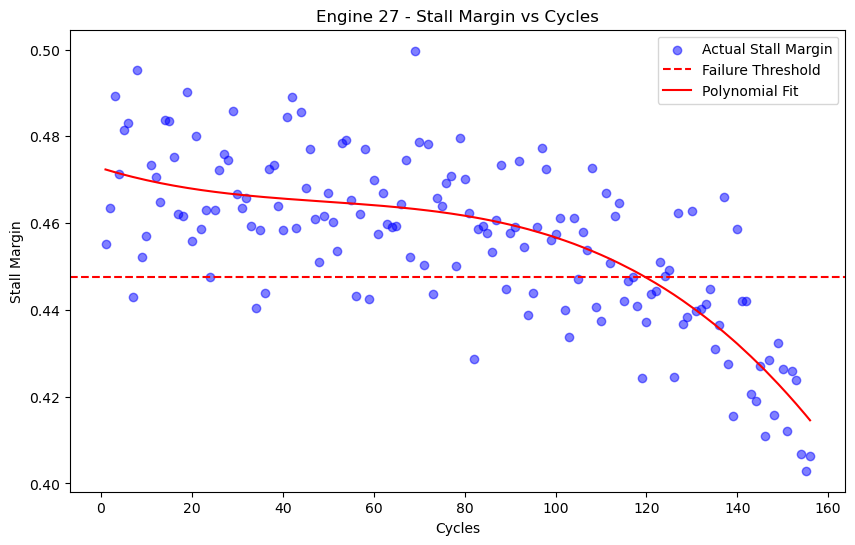

r2 score is:0.23961834288094896


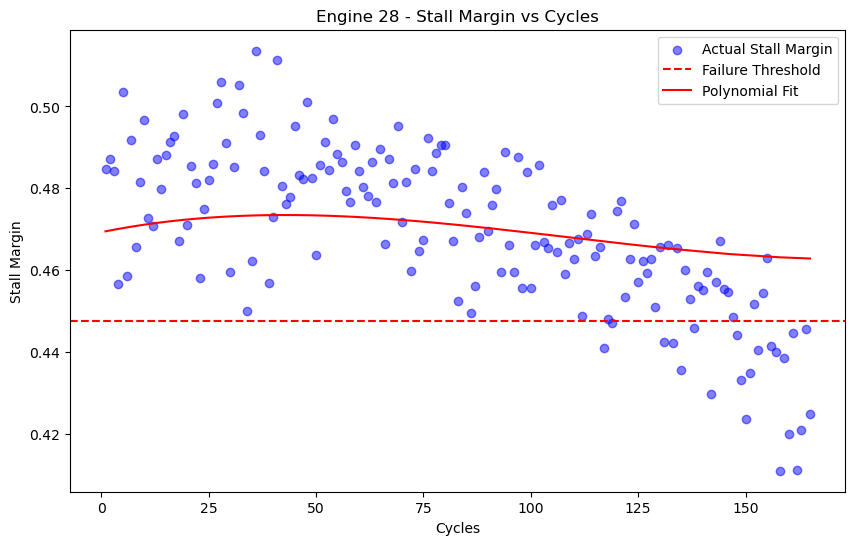

r2 score is:0.42556946452698197


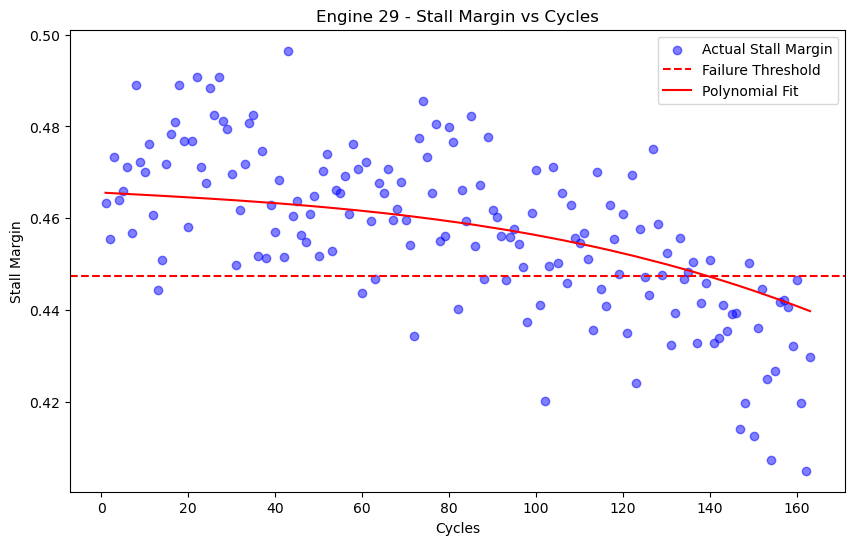

r2 score is:0.674915676524358


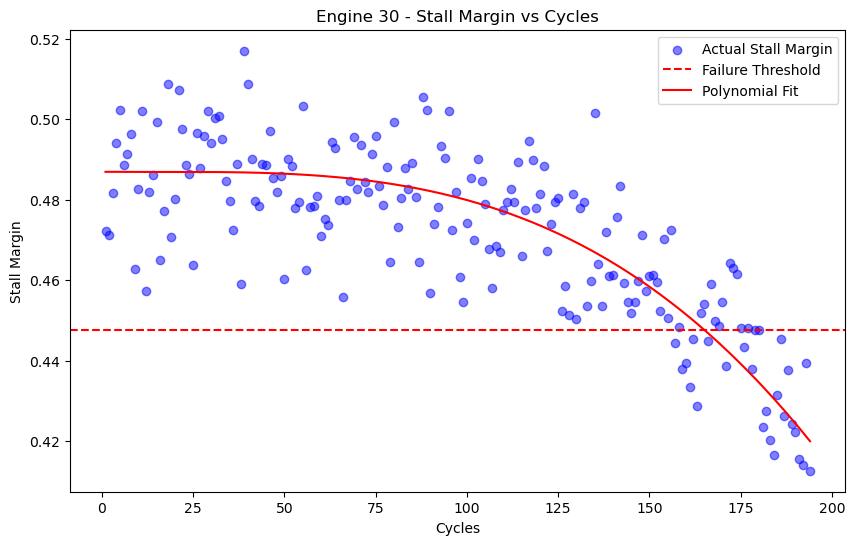

r2 score is:0.6481537349262756


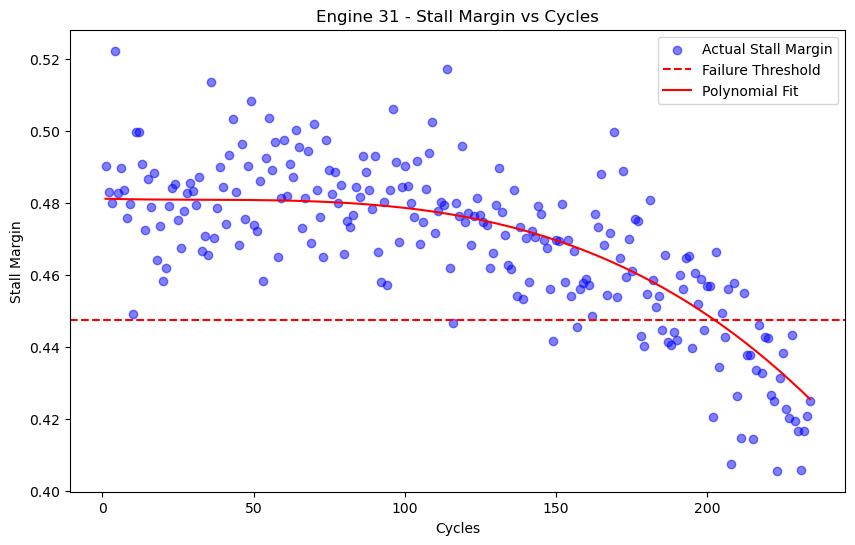

r2 score is:0.5106811328716898


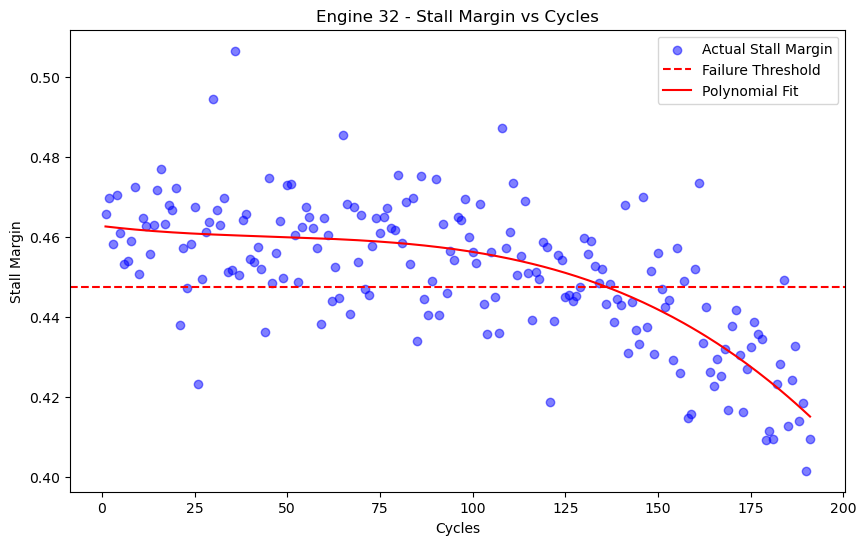

r2 score is:0.6433775801978772


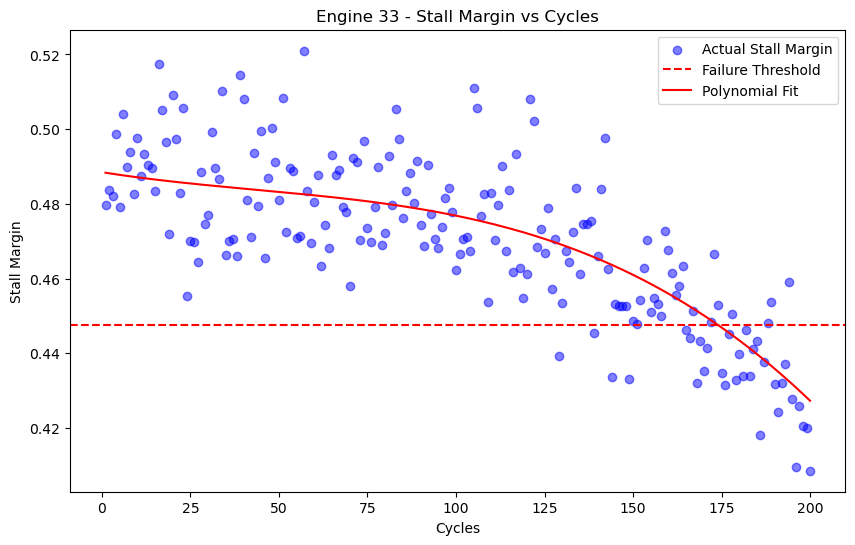

r2 score is:0.48491672118492


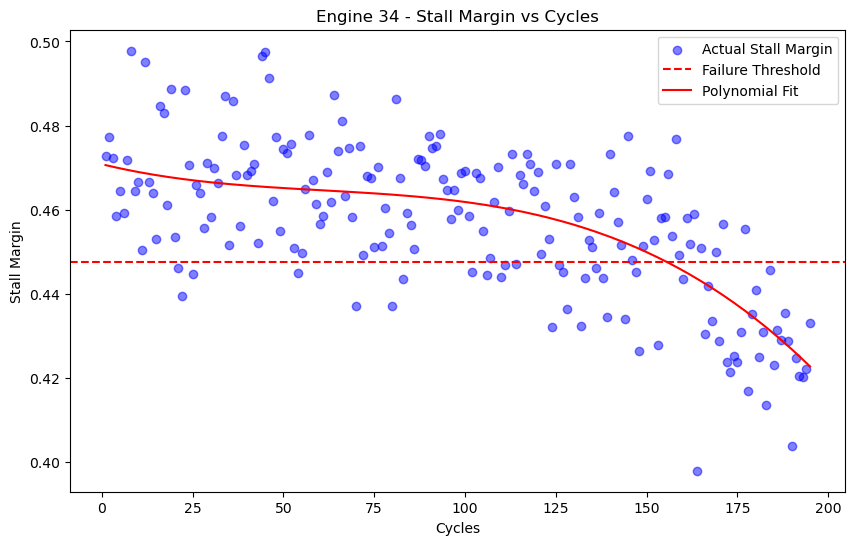

r2 score is:0.6518246995517933


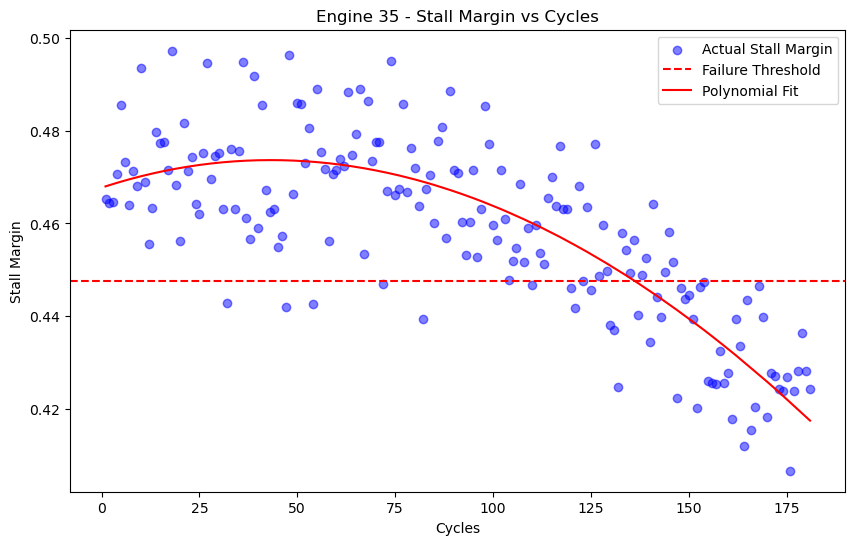

r2 score is:0.3633195604219529


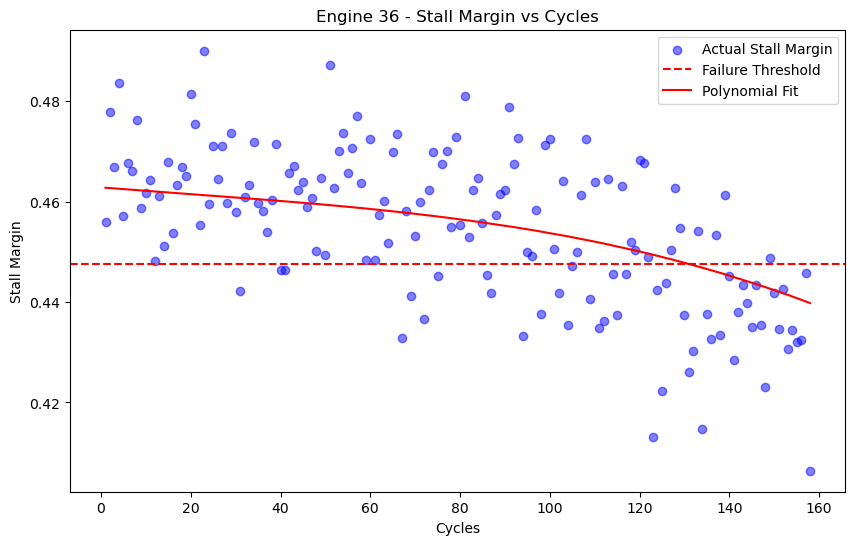

r2 score is:0.46697335896657144


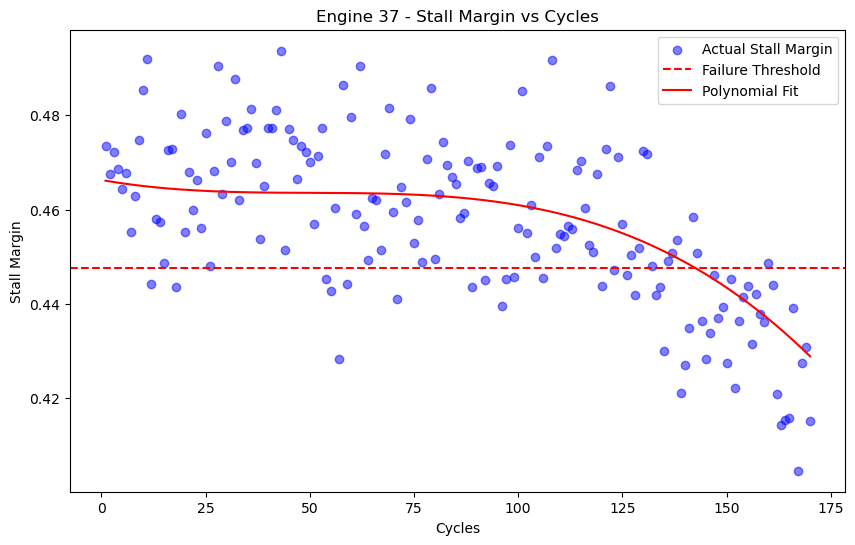

r2 score is:0.4413773951968488


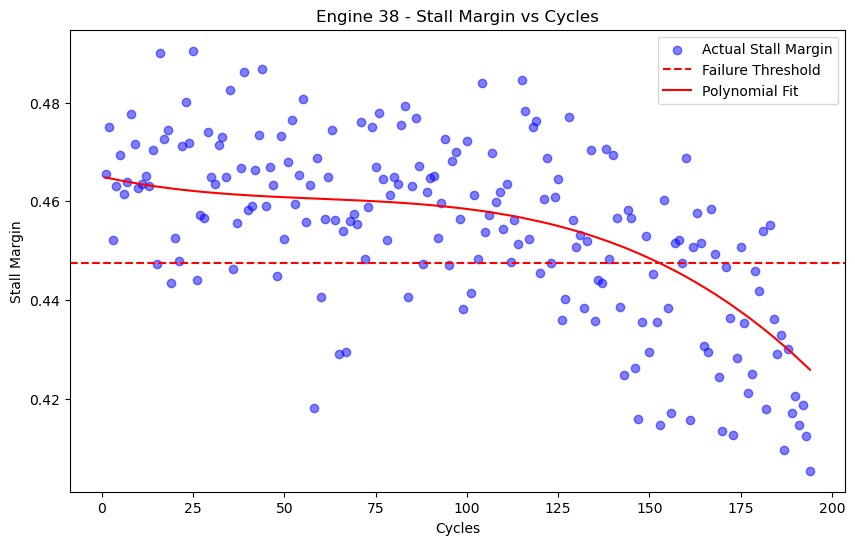

r2 score is:0.49367752057009306


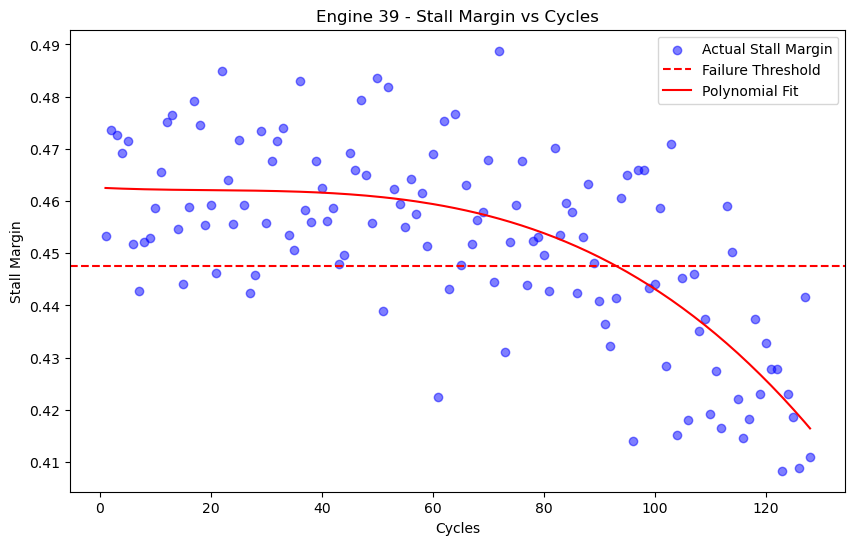

r2 score is:0.559584439801246


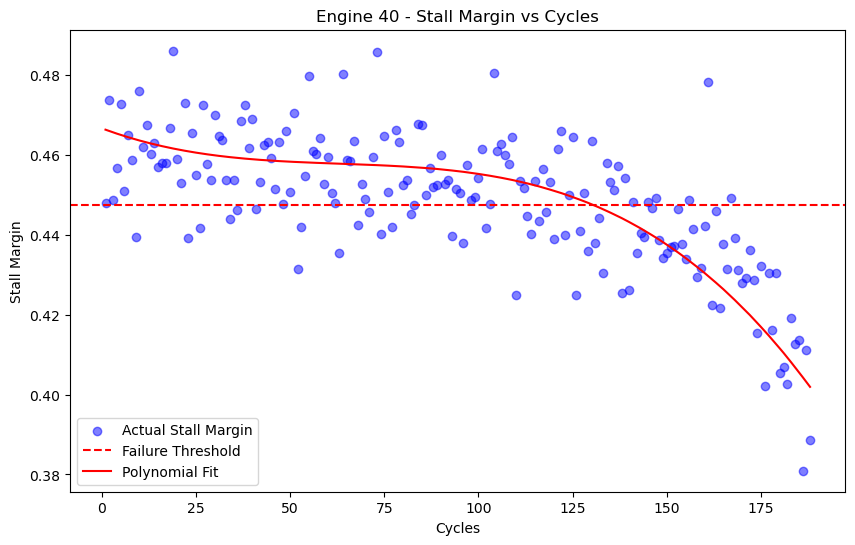

r2 score is:0.6453695512268358


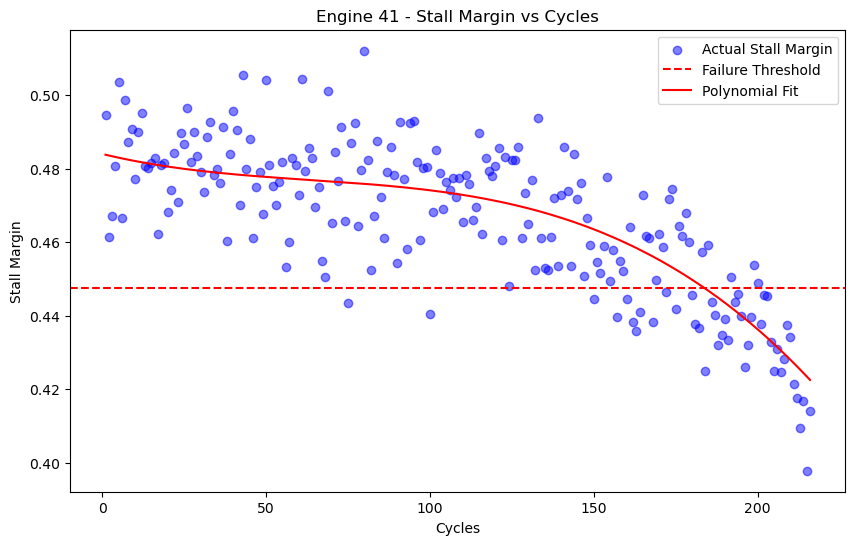

r2 score is:0.5273859693622276


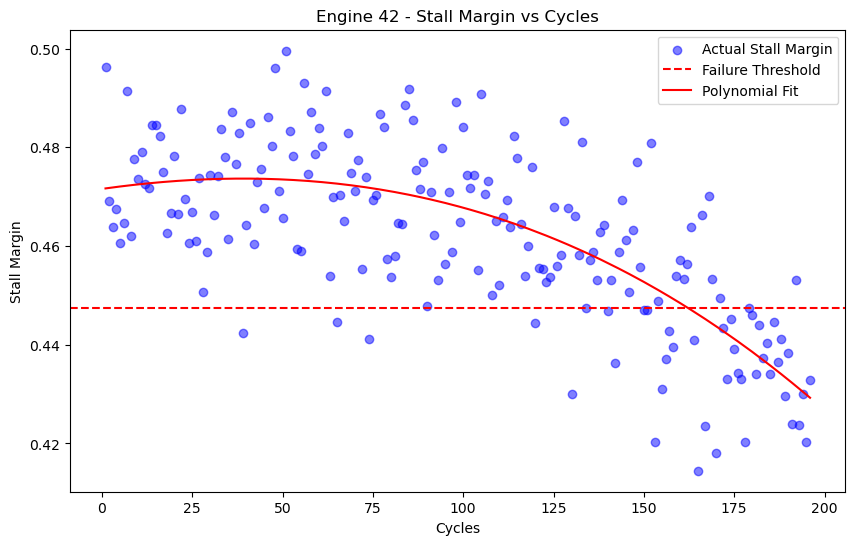

r2 score is:0.6297676184218157


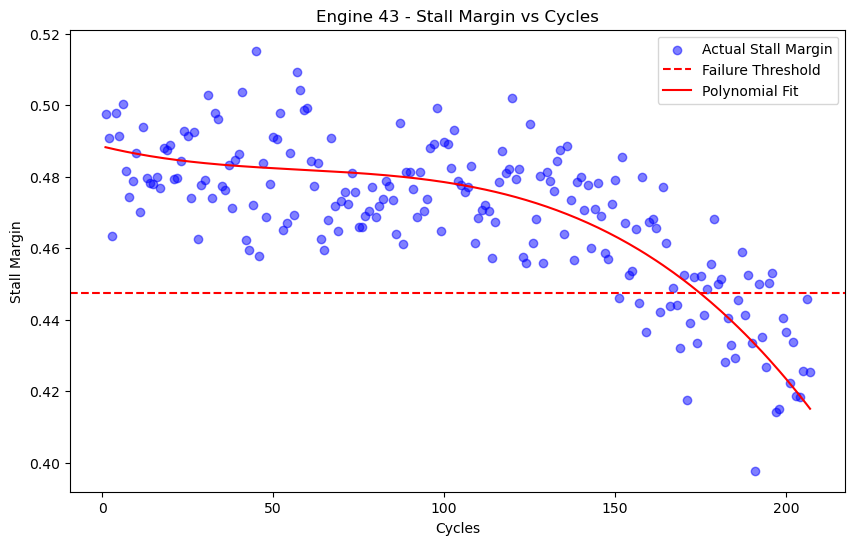

r2 score is:0.6325651786930604


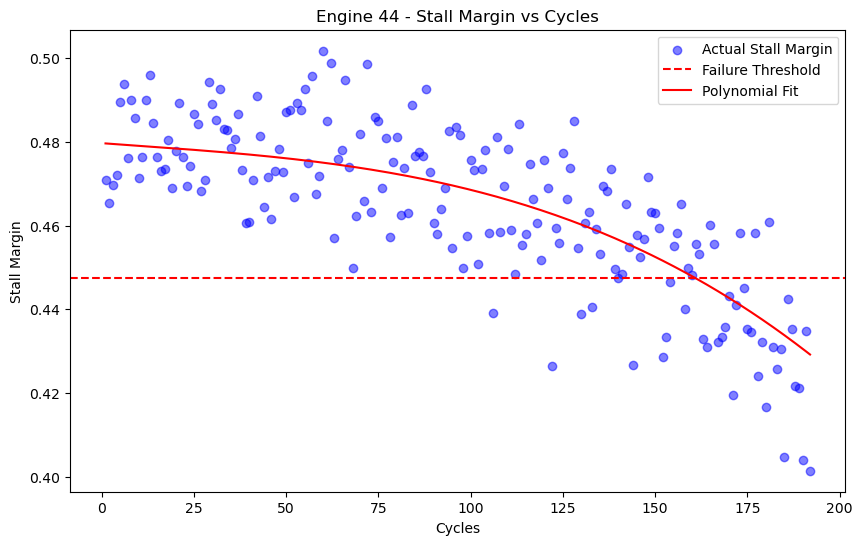

r2 score is:0.6827822396801901


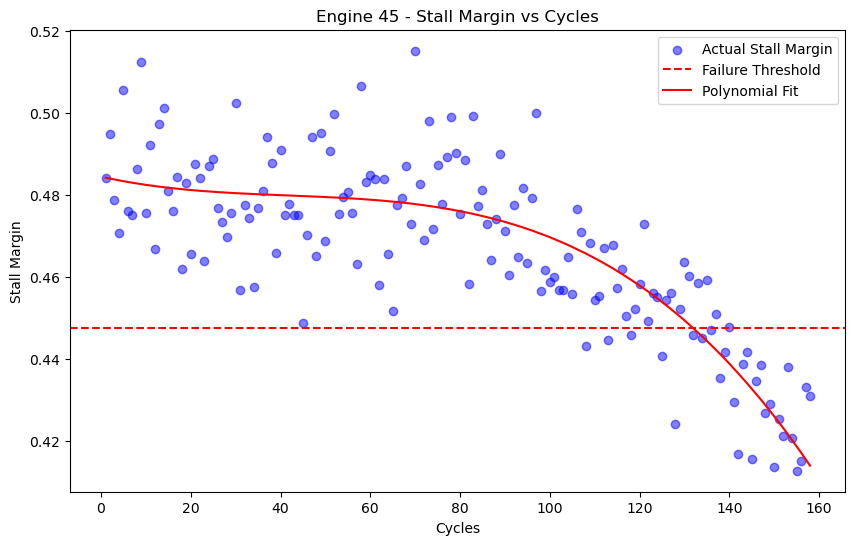

r2 score is:0.5889558039253802


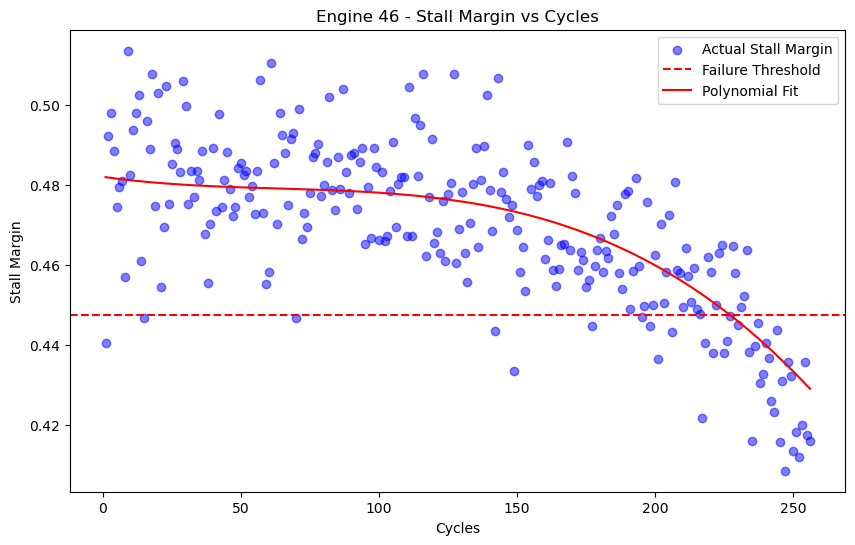

r2 score is:0.7111377697118038


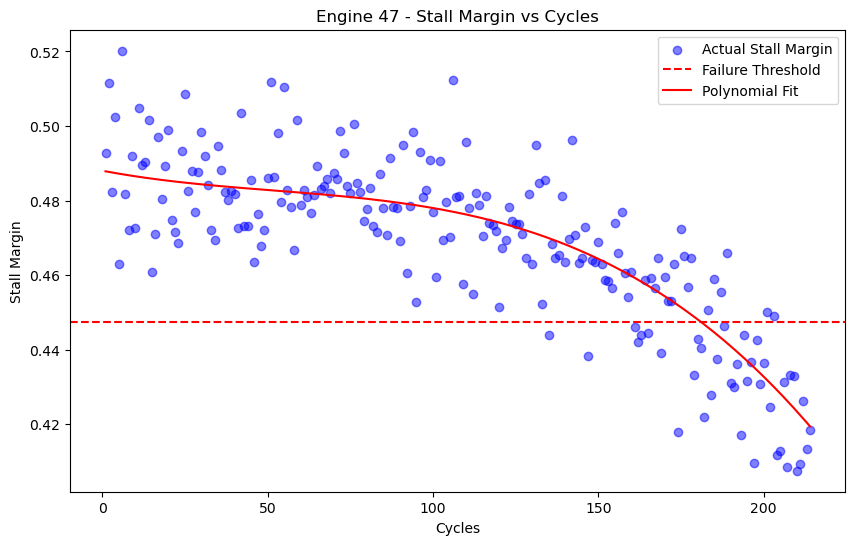

r2 score is:0.6352166235499115


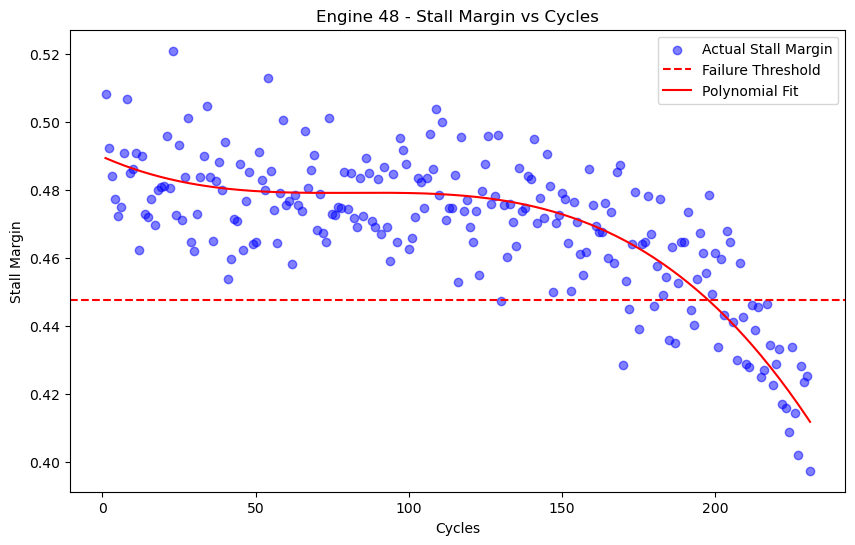

r2 score is:0.28944099818273605


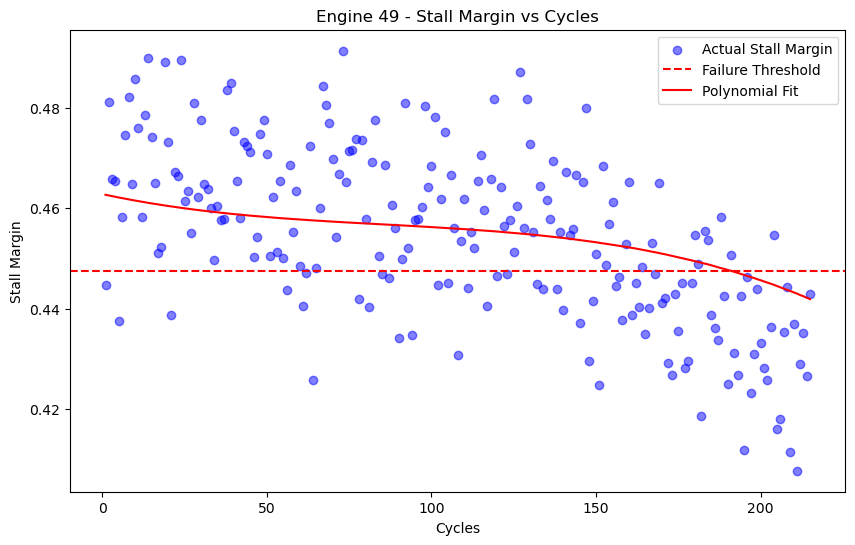

r2 score is:0.5845163619746852


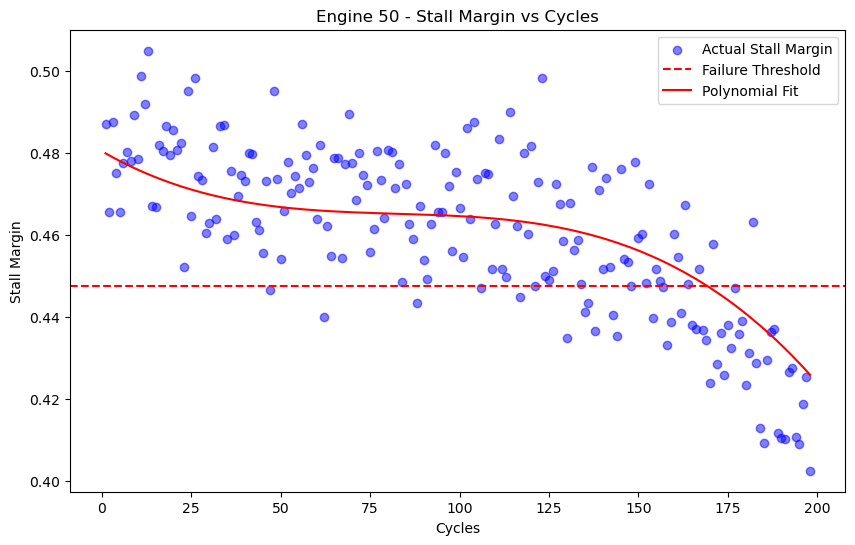

r2 score is:0.598447253157639


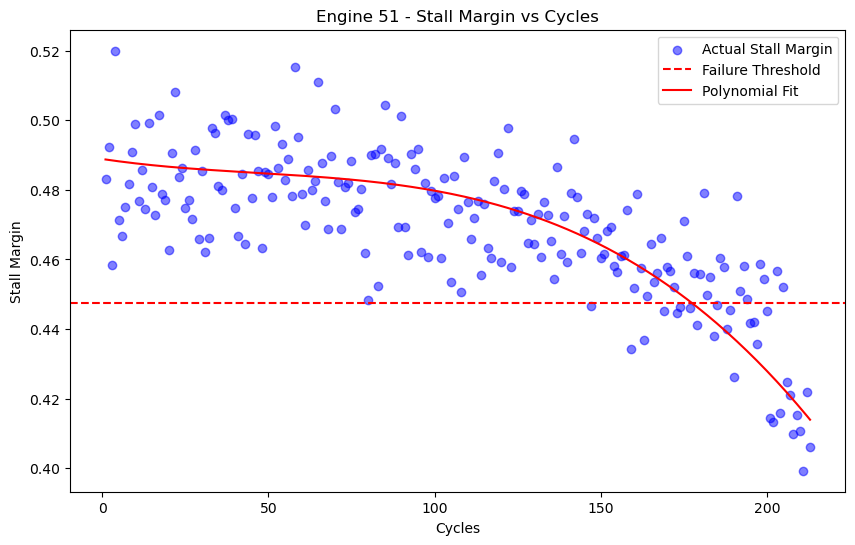

r2 score is:0.5918967650440942


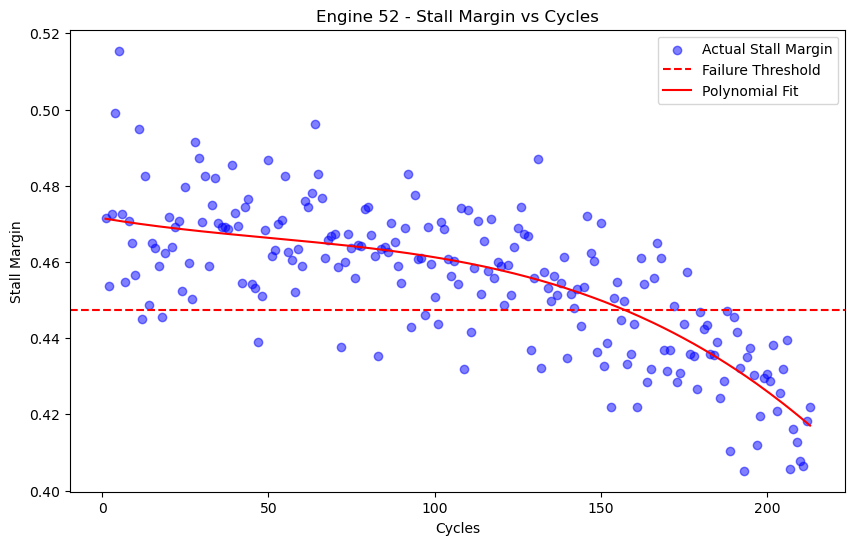

r2 score is:0.6318788585059751


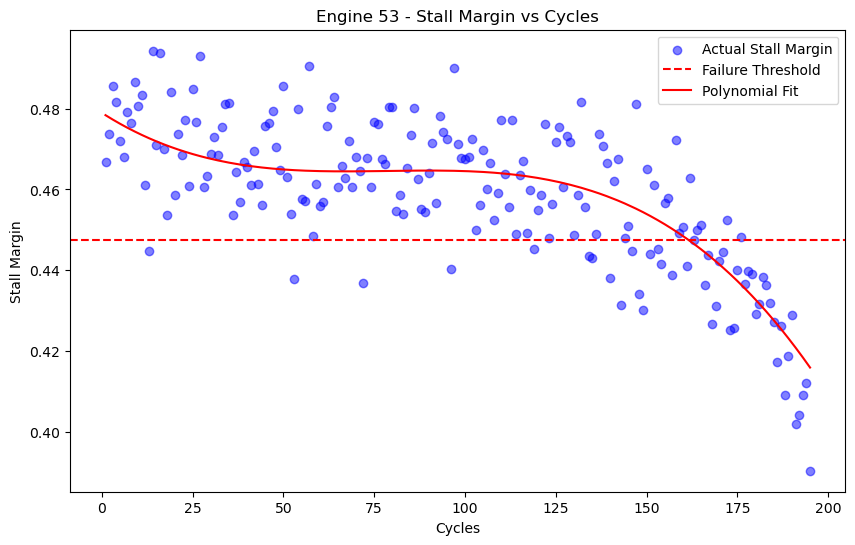

r2 score is:0.6144631372682712


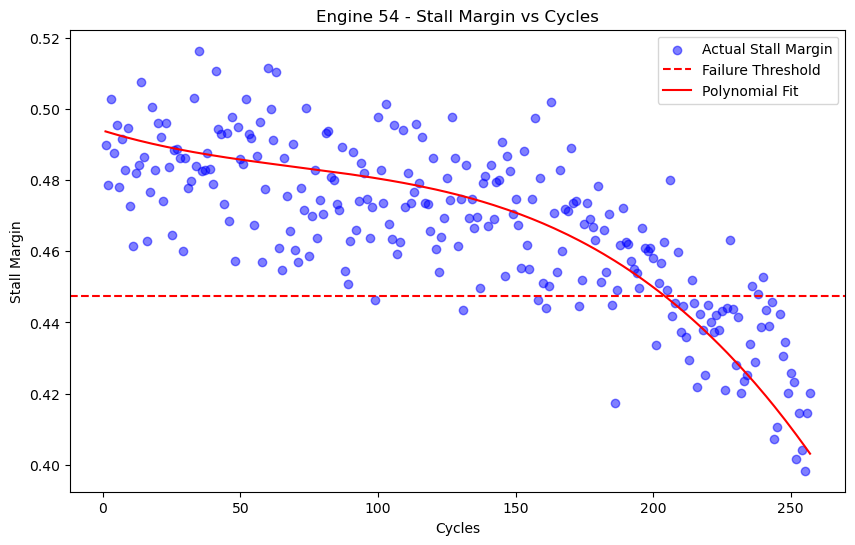

r2 score is:0.3732731377219596


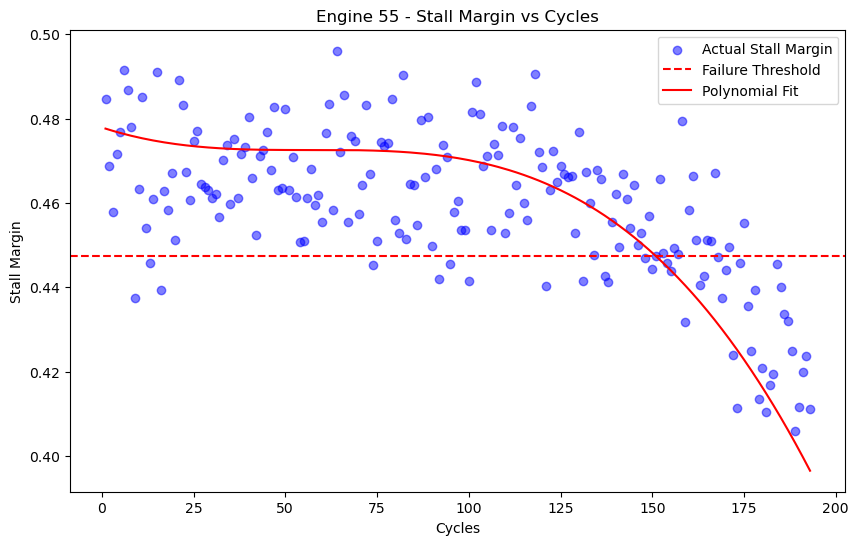

r2 score is:0.432584357695593


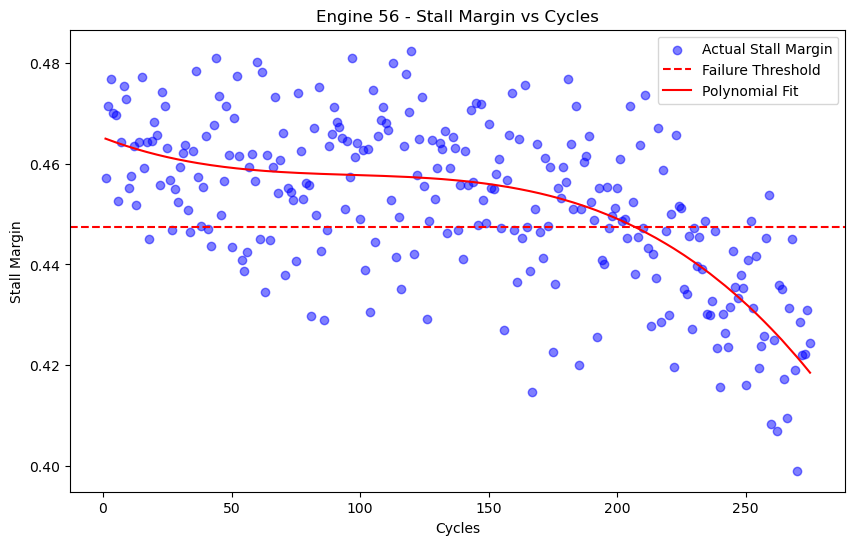

r2 score is:0.5675070315405182


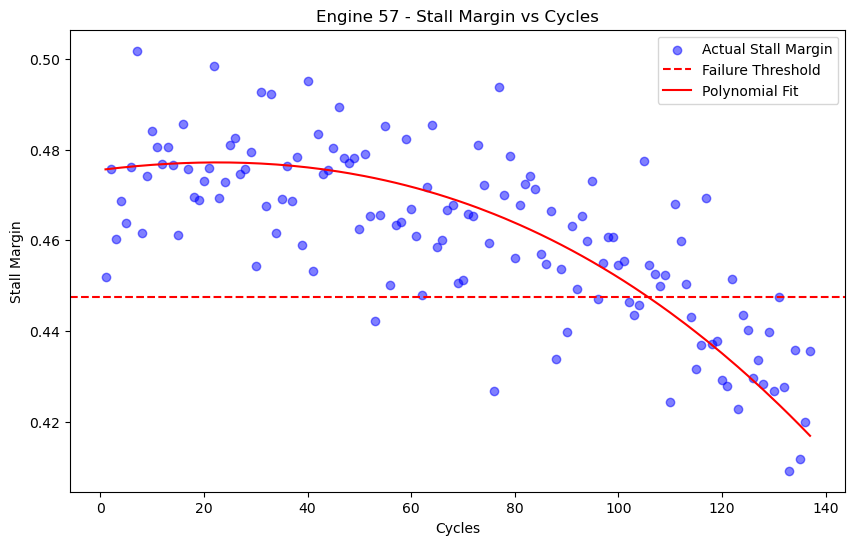

r2 score is:0.4589603239704716


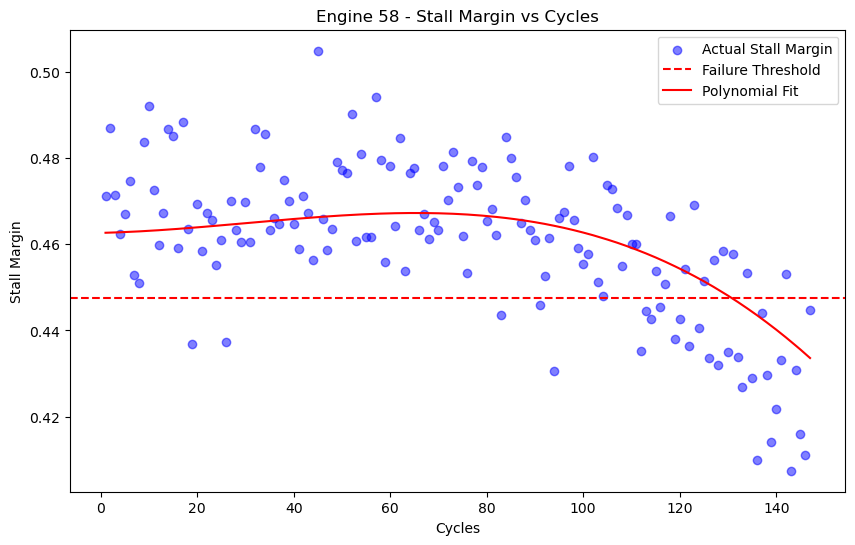

r2 score is:0.6427757663306903


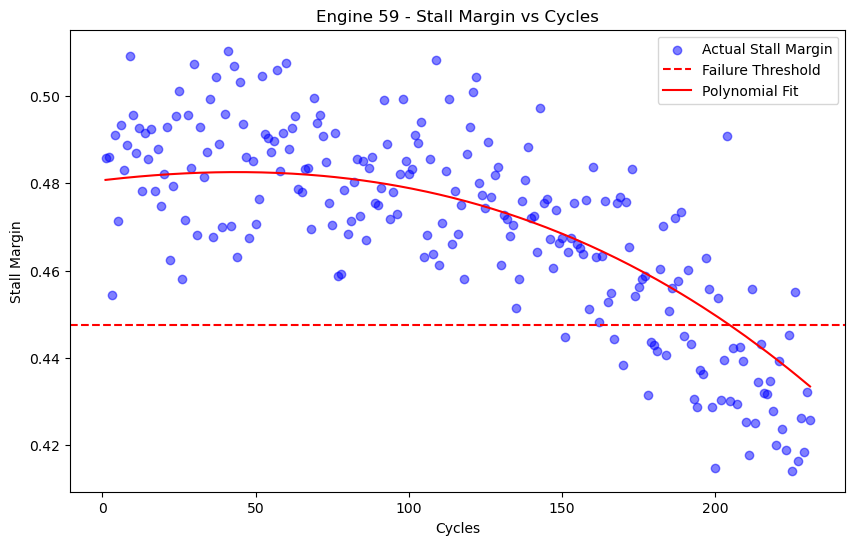

r2 score is:0.6097327072678393


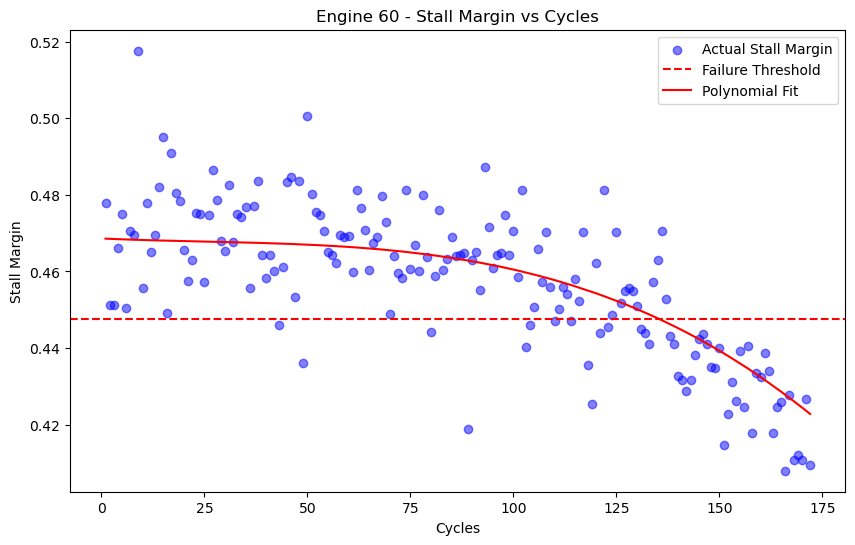

r2 score is:0.6550560886567703


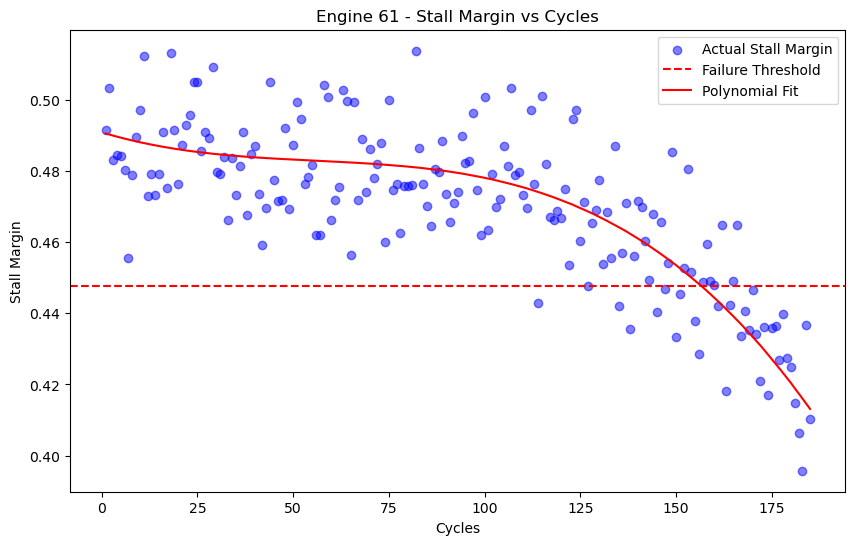

r2 score is:0.29448880339788


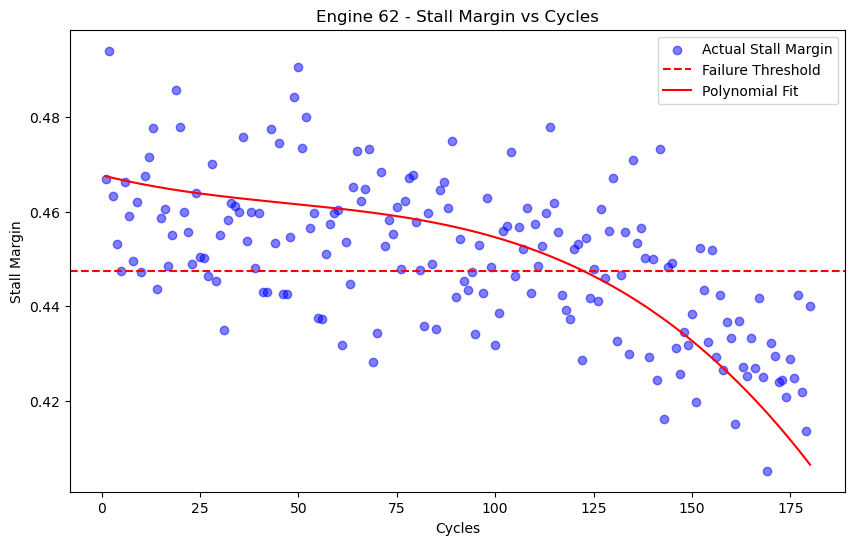

r2 score is:0.48753036873742817


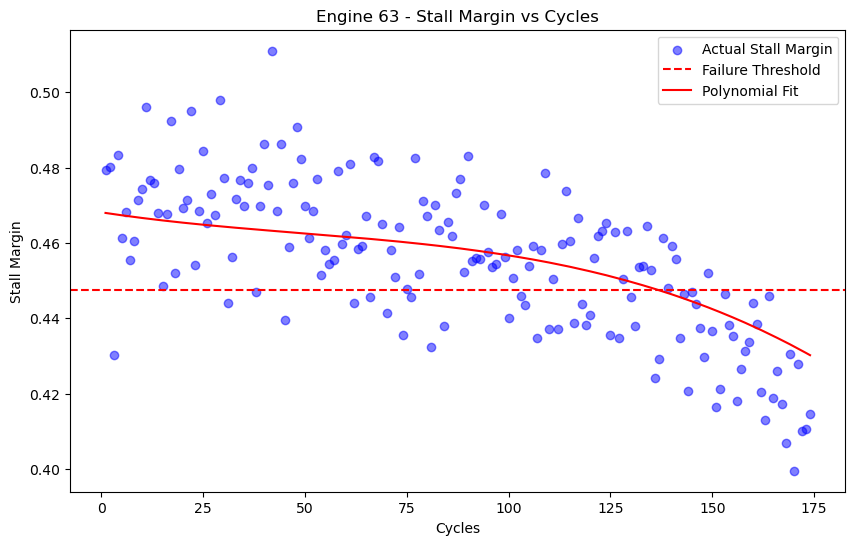

r2 score is:0.6527384238607172


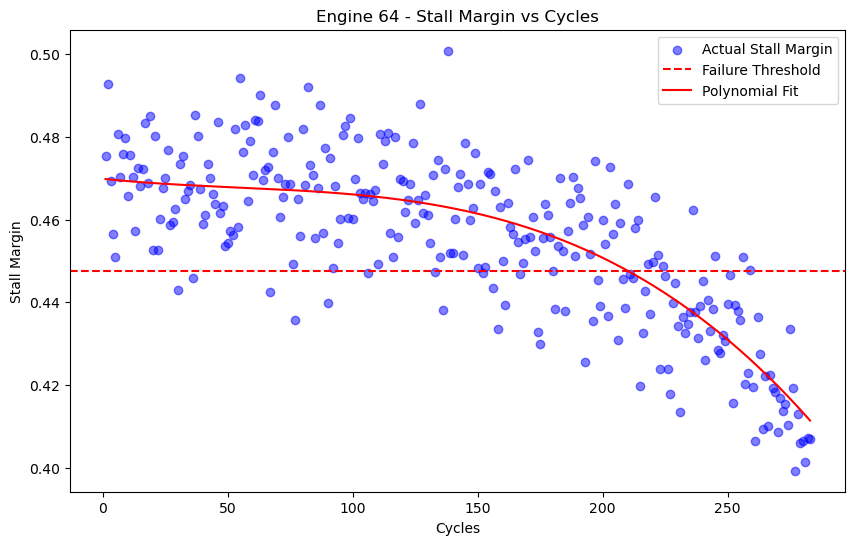

r2 score is:0.5932485786159689


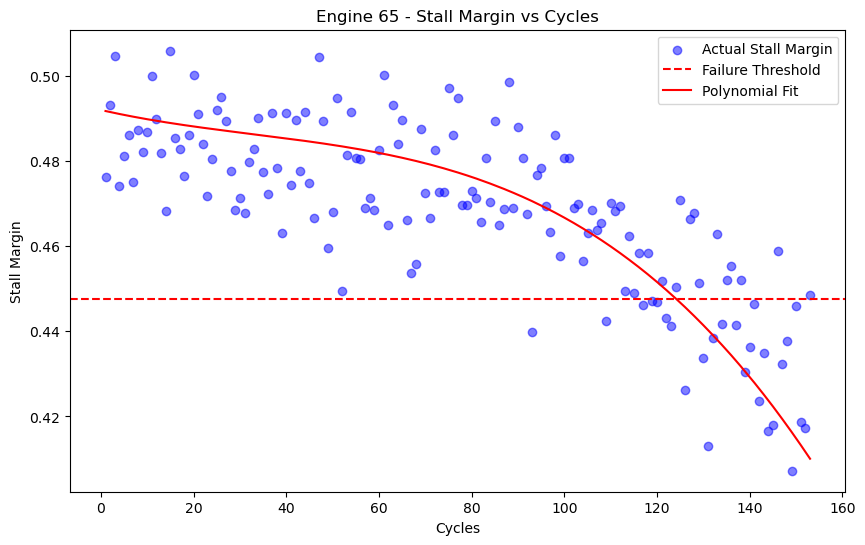

r2 score is:0.48310518620318965


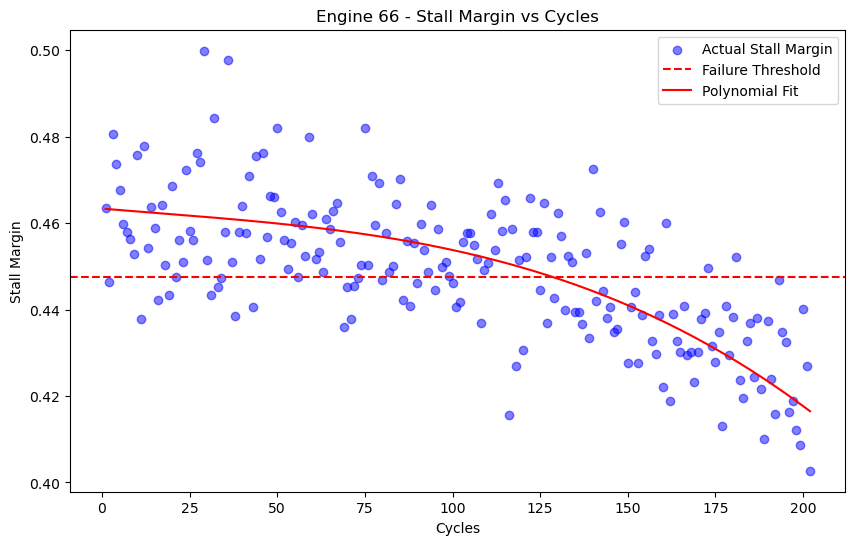

r2 score is:0.5664923539611326


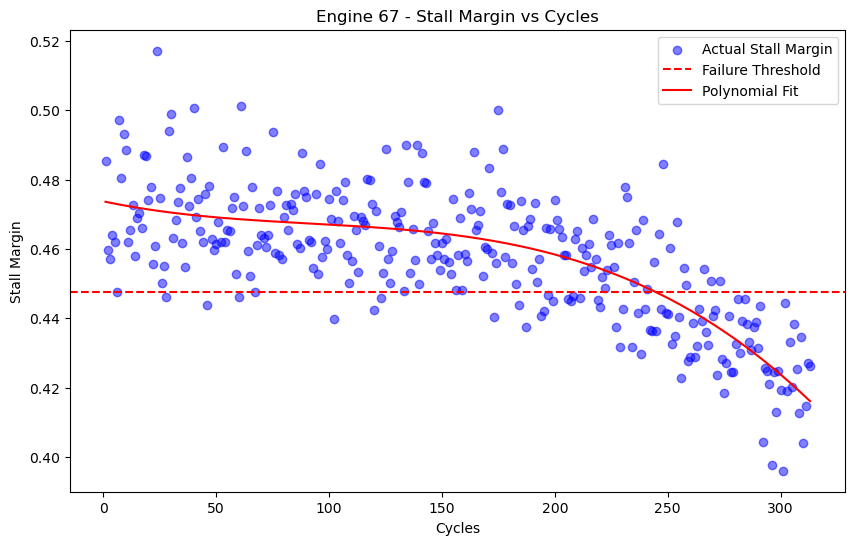

r2 score is:0.6042676258247341


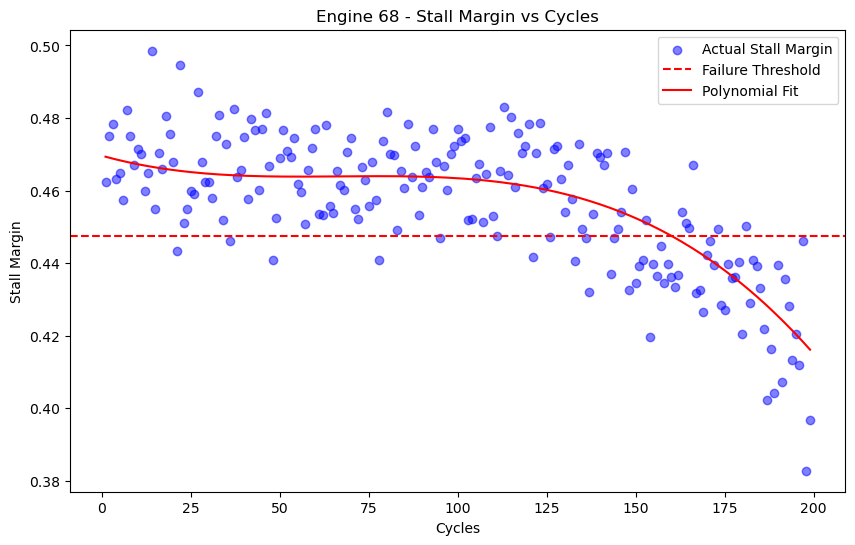

r2 score is:0.5491223154159529


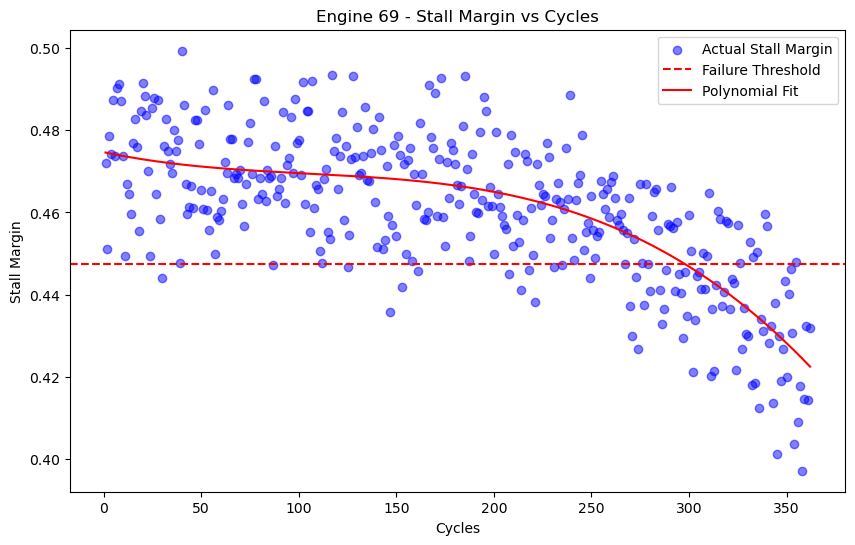

r2 score is:0.4044236570523798


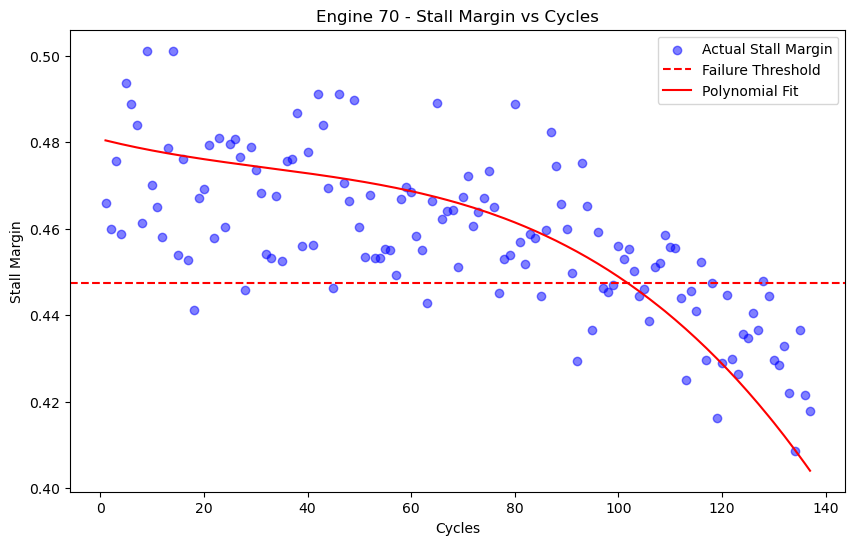

r2 score is:0.49568433822434543


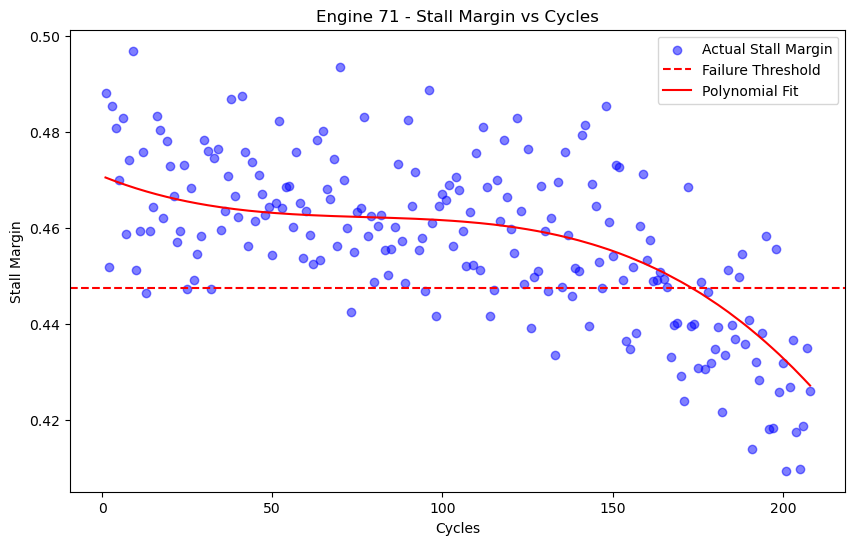

r2 score is:0.5855542194784686


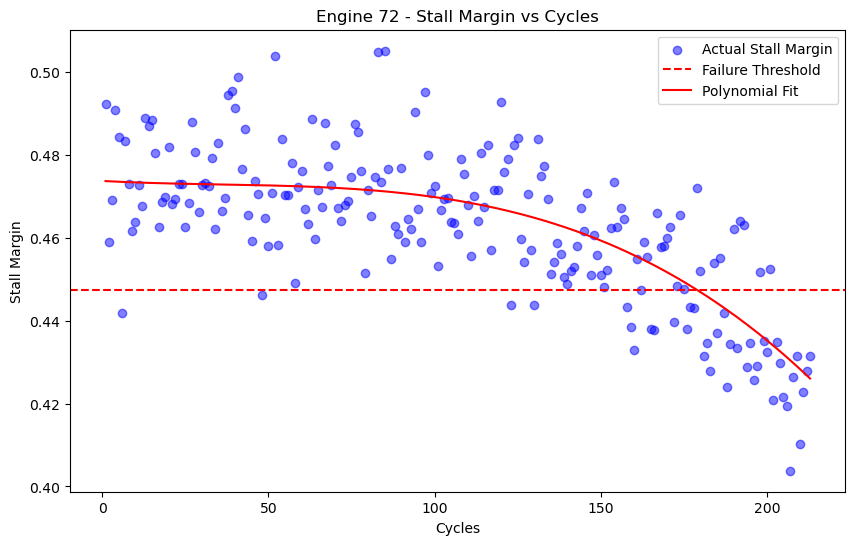

r2 score is:0.40273479422755676


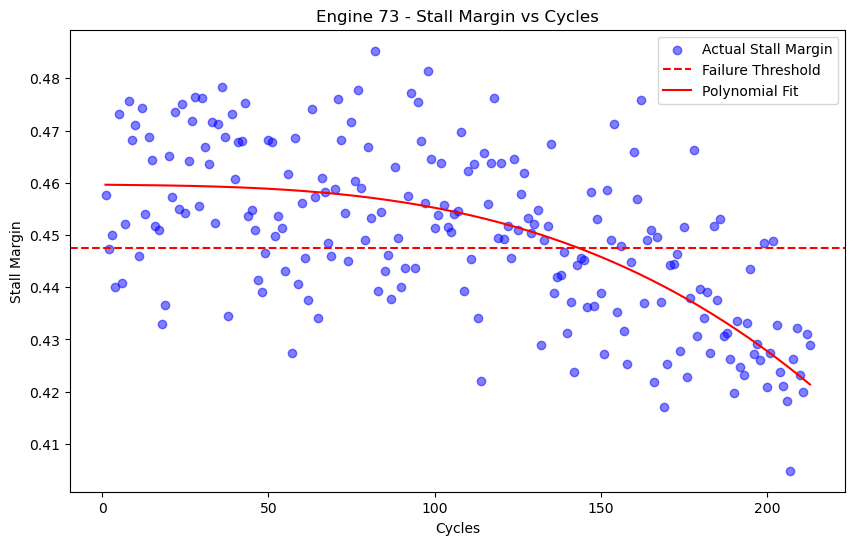

r2 score is:0.5470540488505797


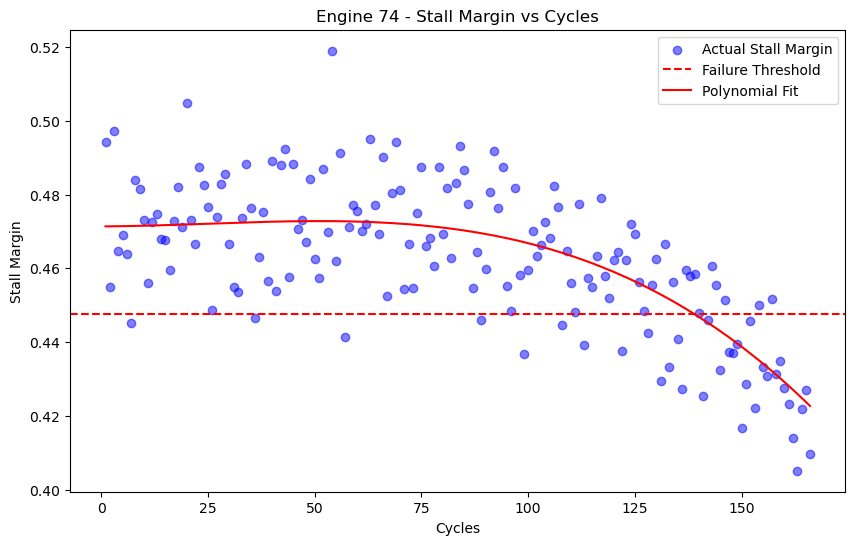

r2 score is:0.14509267545670346


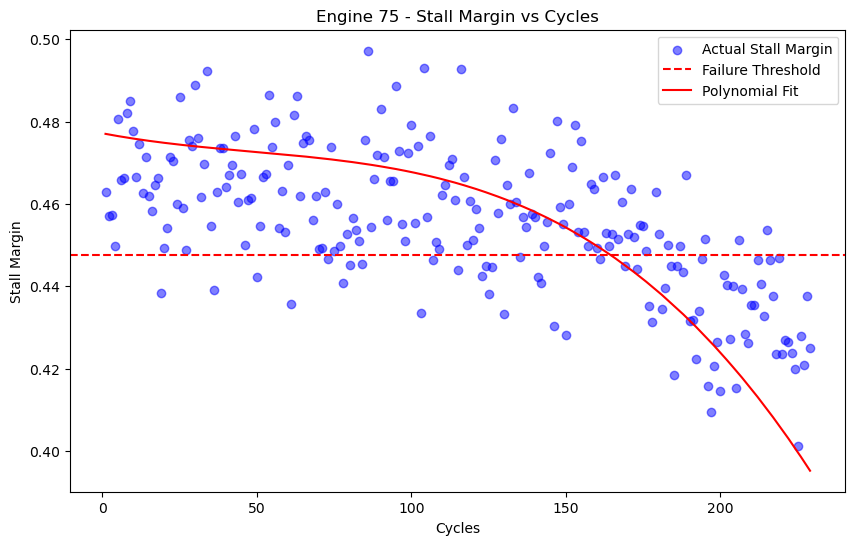

r2 score is:0.40526913950843624


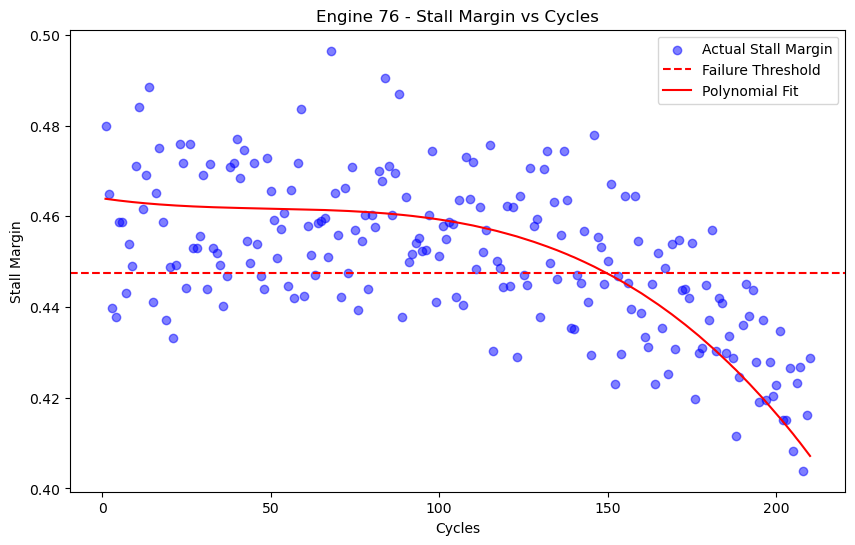

r2 score is:0.4361106937646976


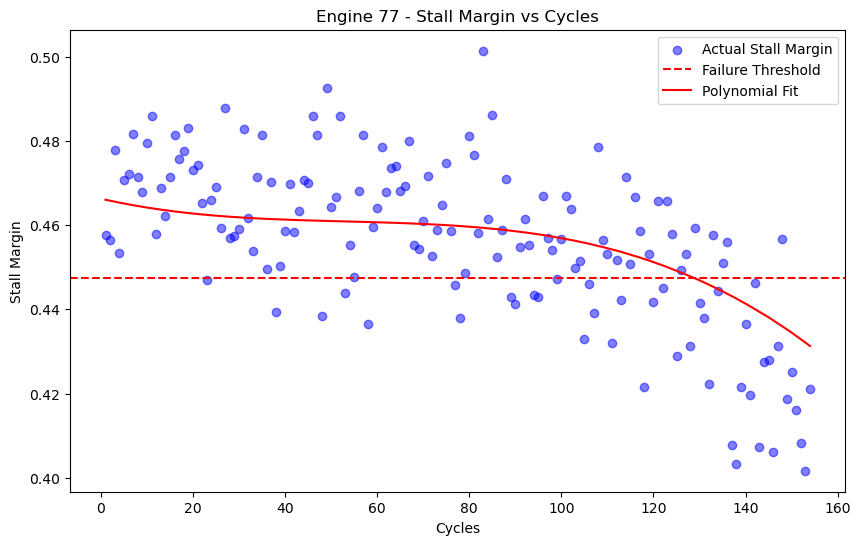

r2 score is:0.6410357876175532


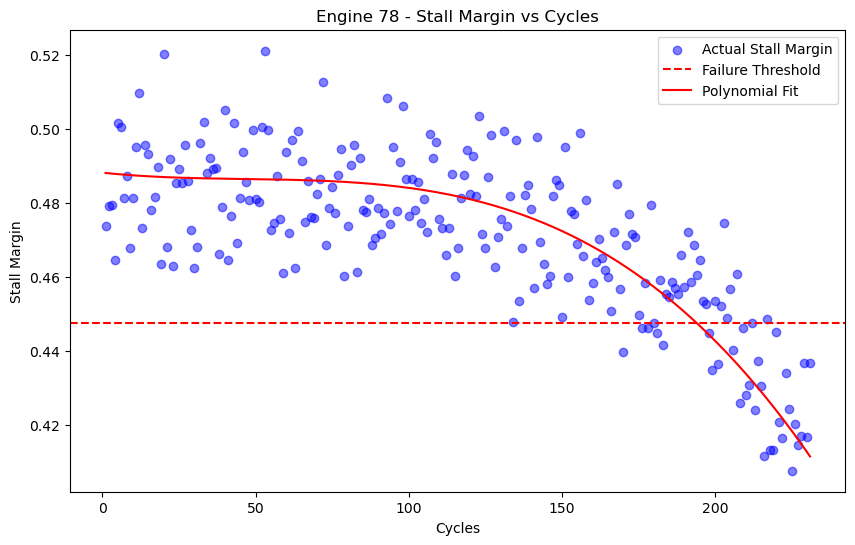

r2 score is:0.6822989253219198


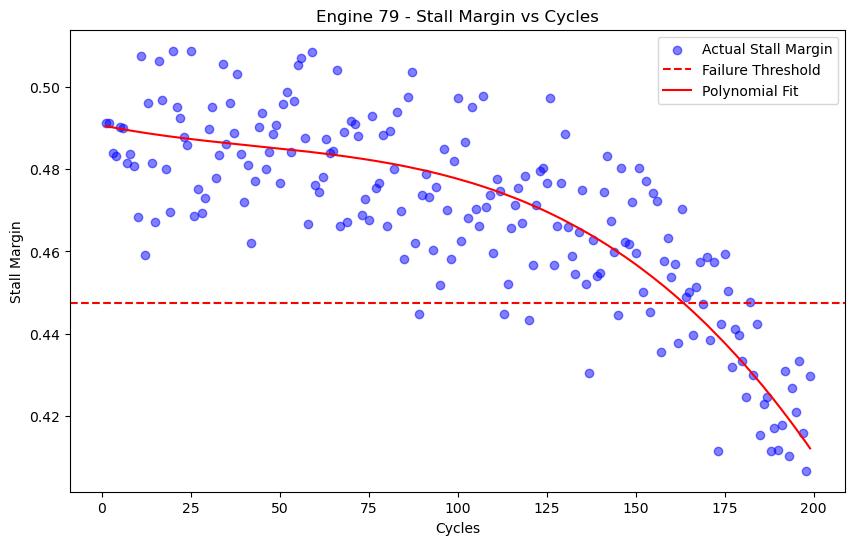

r2 score is:0.20363920955578962


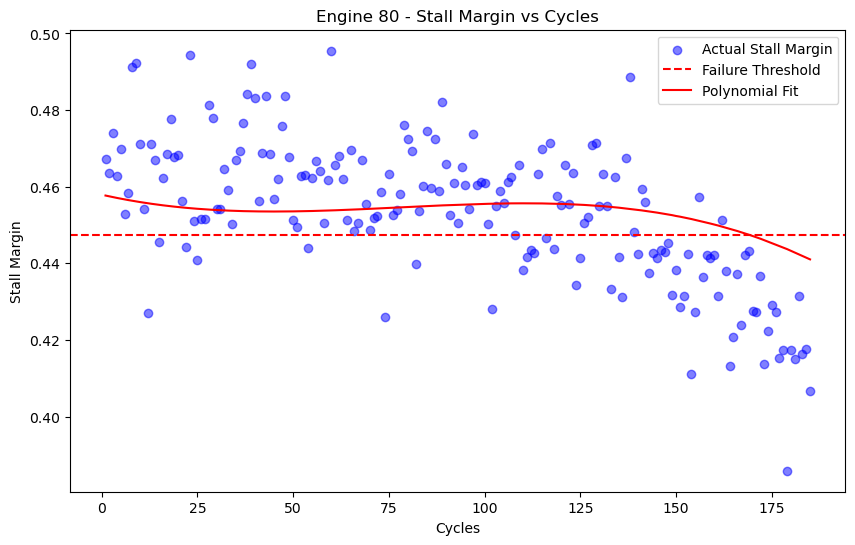

r2 score is:0.5092905673983779


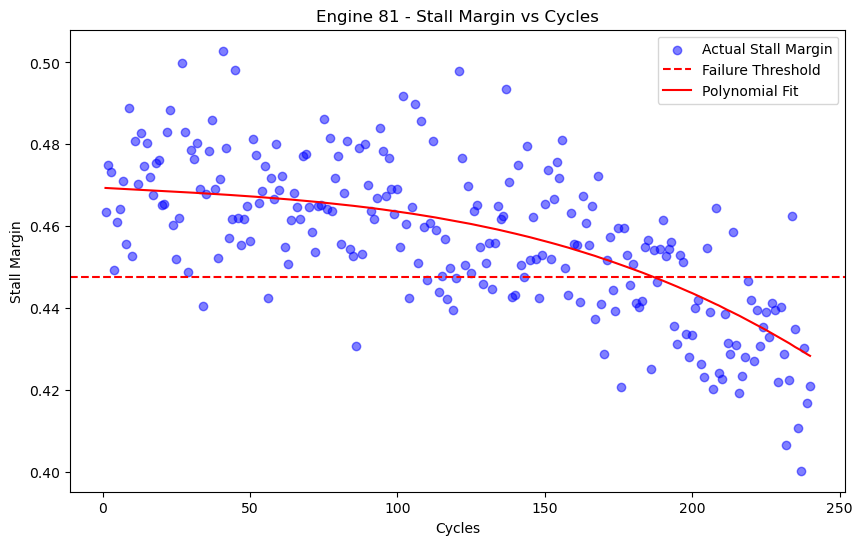

r2 score is:0.6397170643907102


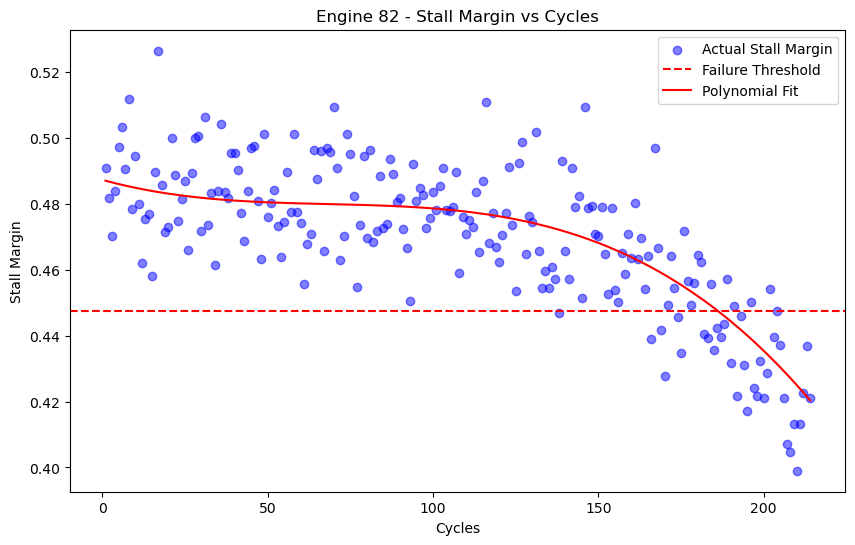

r2 score is:0.6237134669140133


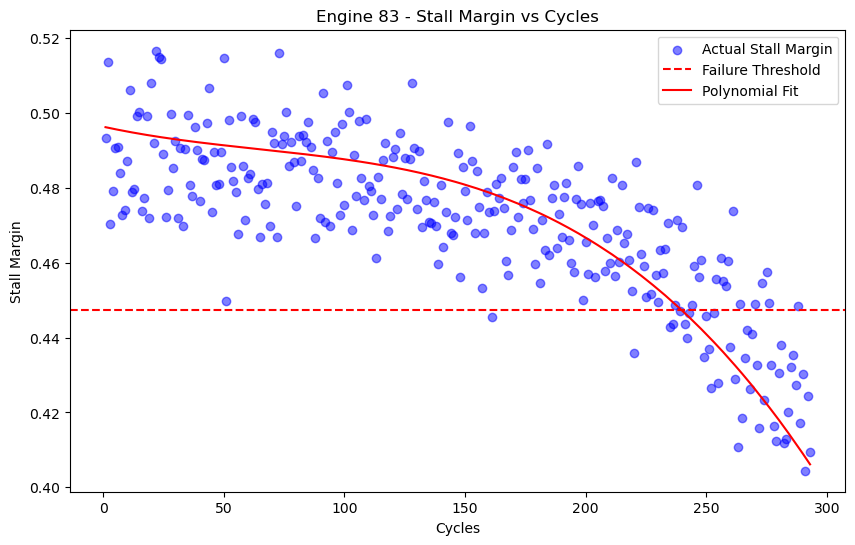

r2 score is:0.48395600818158235


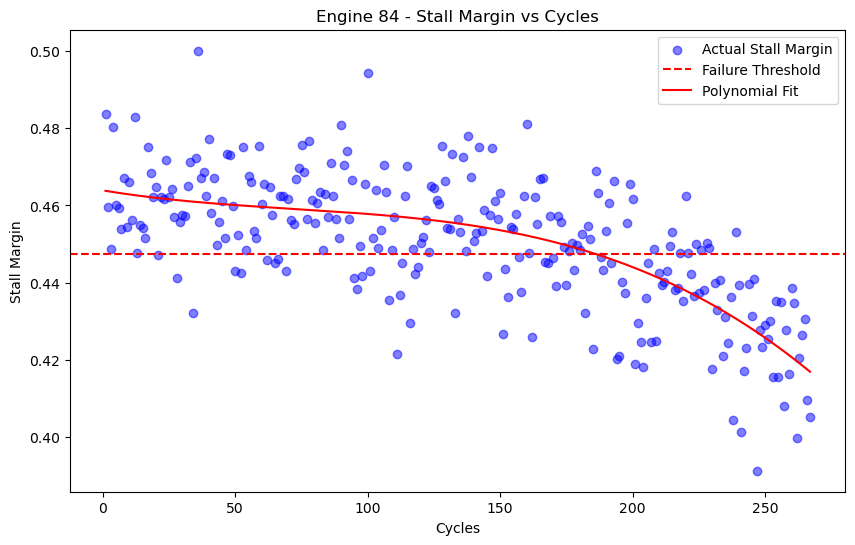

r2 score is:0.5106013000250273


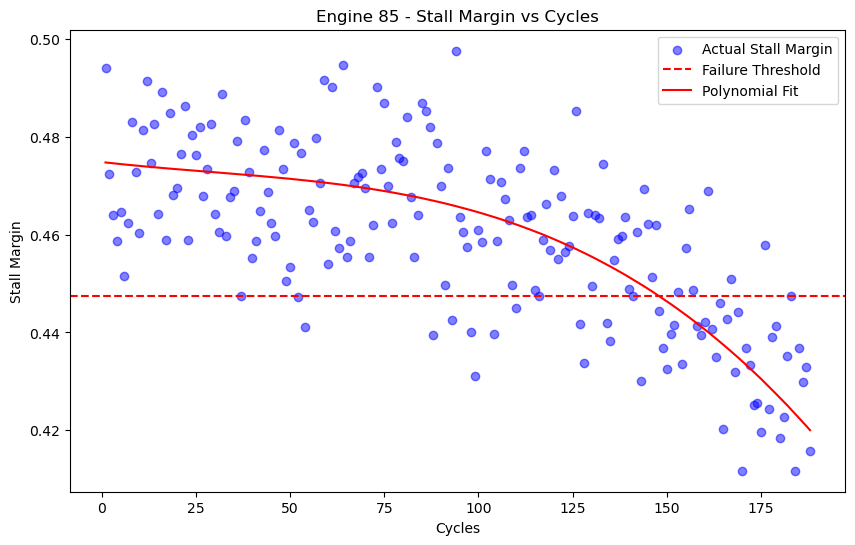

r2 score is:0.4872950222976189


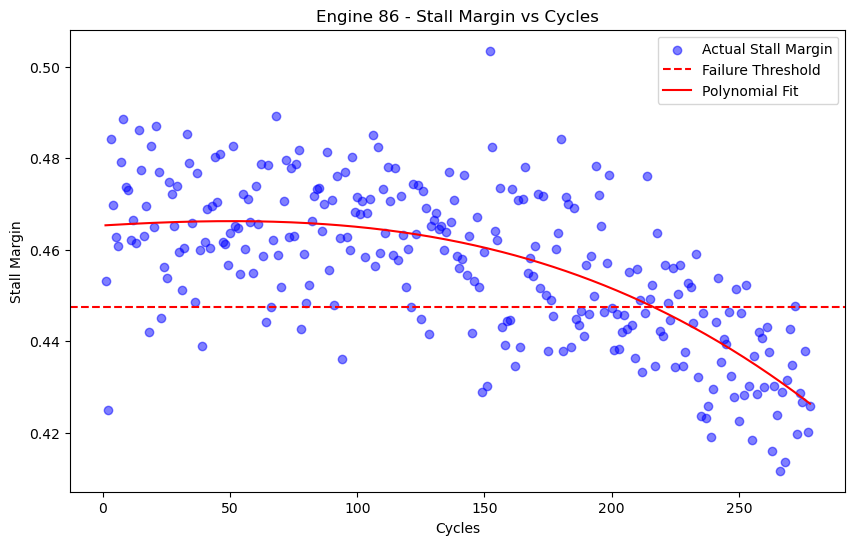

r2 score is:0.5565888896506672


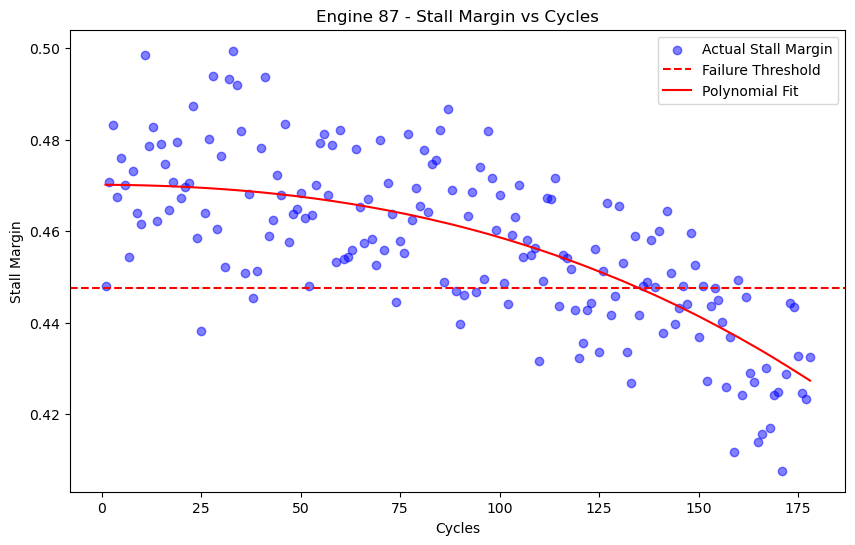

r2 score is:0.5650101818979202


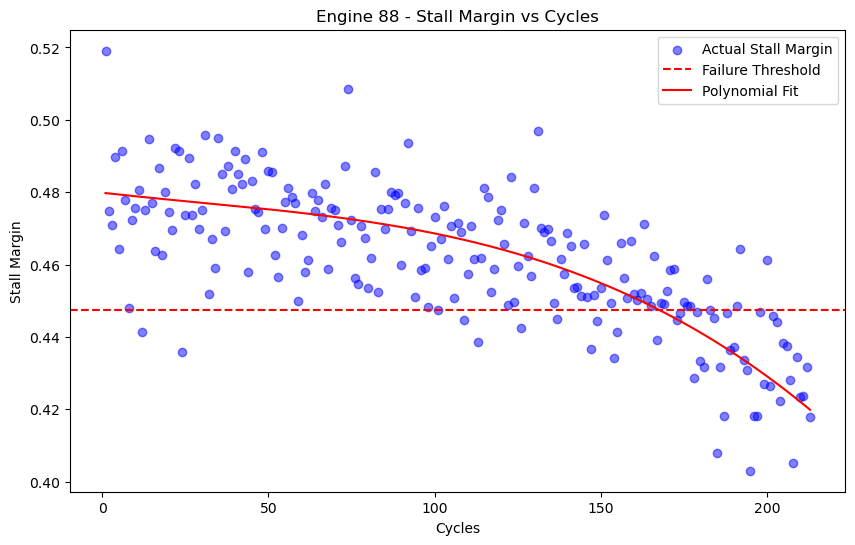

r2 score is:0.6265377859066823


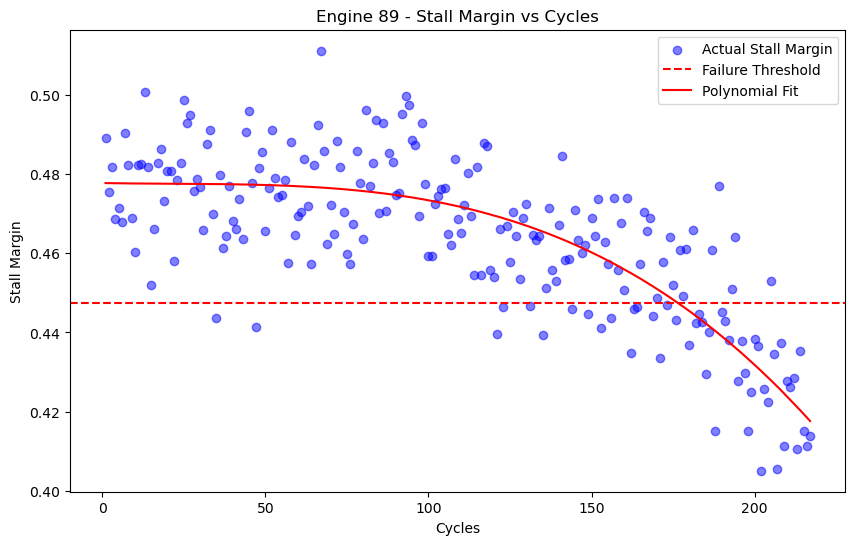

r2 score is:0.5073238975504766


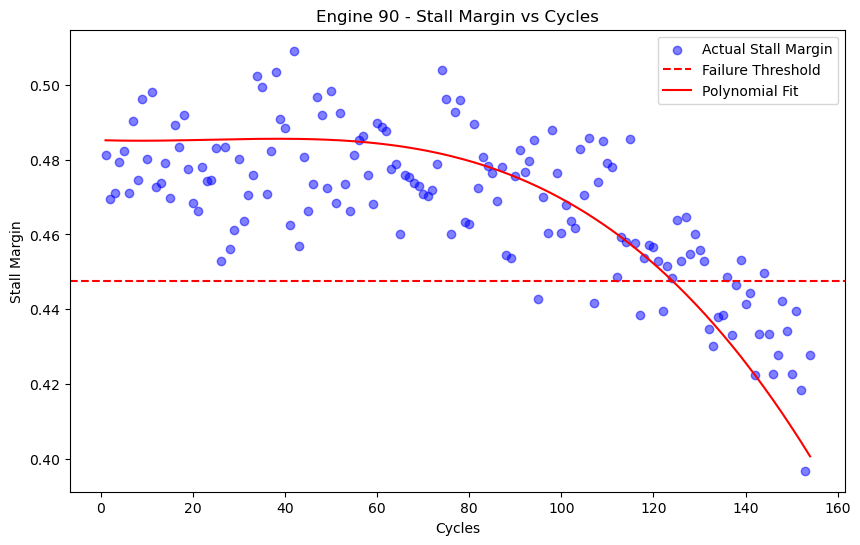

r2 score is:0.42480239634274863


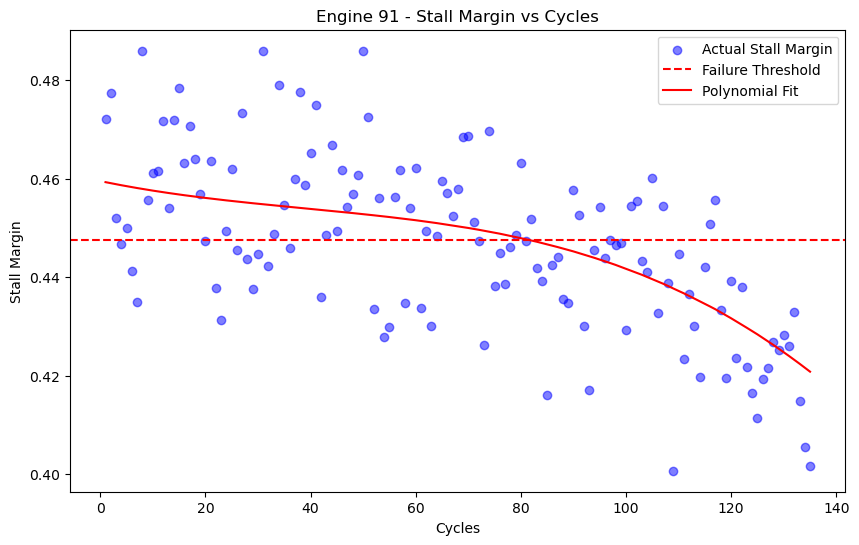

r2 score is:0.605605578169055


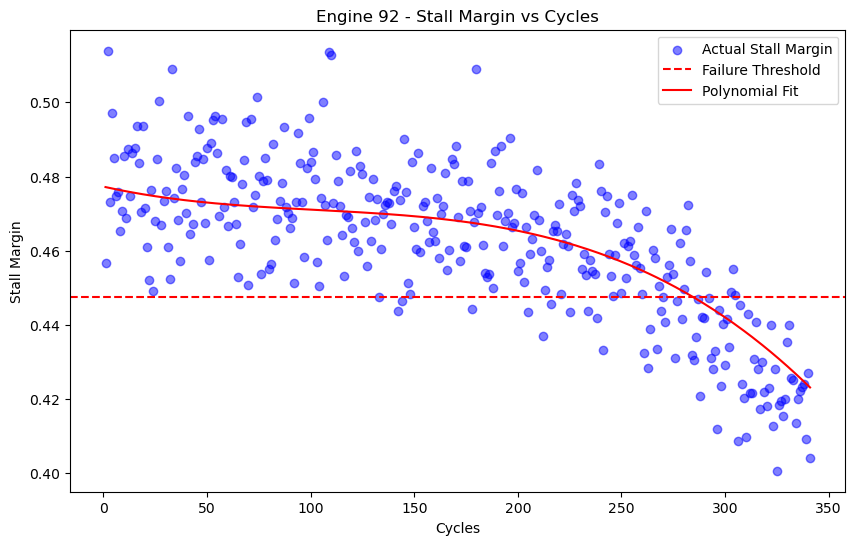

r2 score is:0.6059147924440345


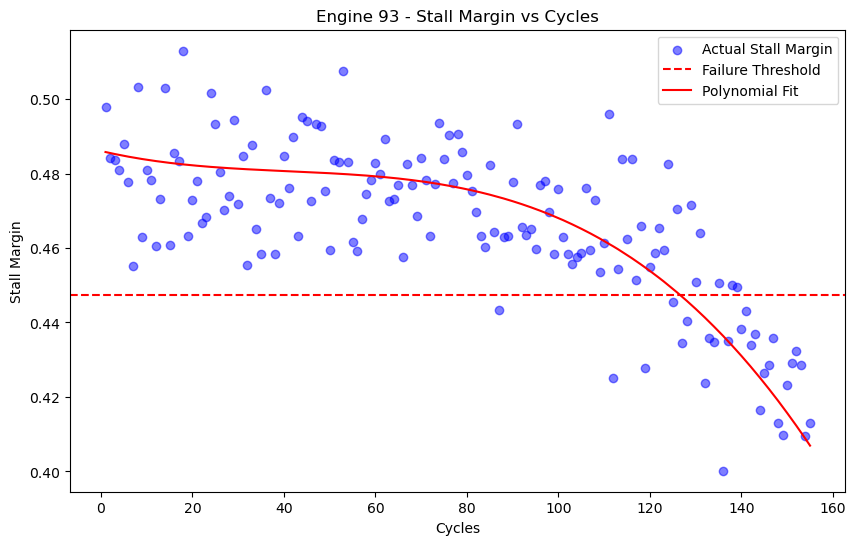

r2 score is:0.4710781176037451


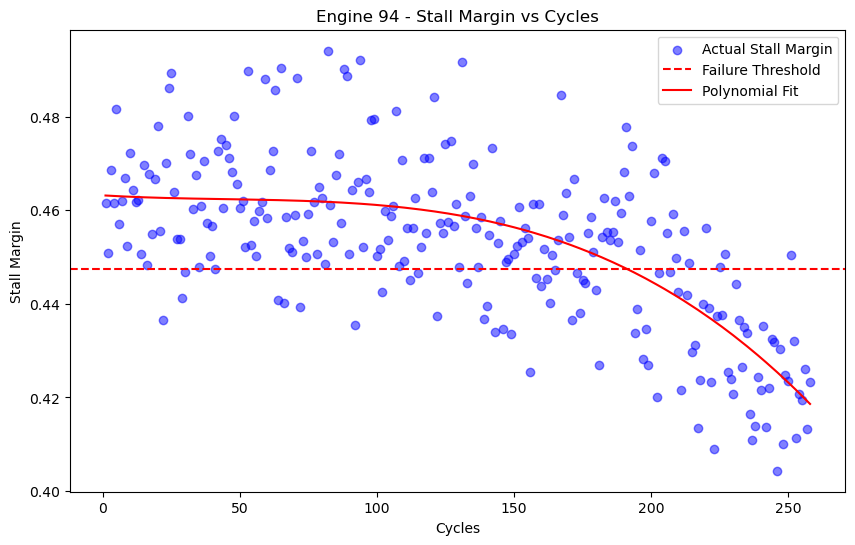

r2 score is:0.6391728382471868


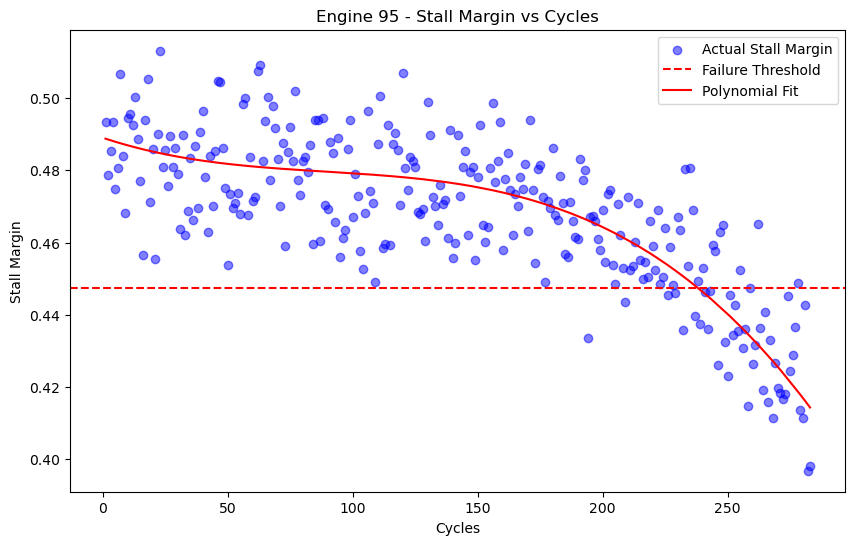

r2 score is:0.6237656327770169


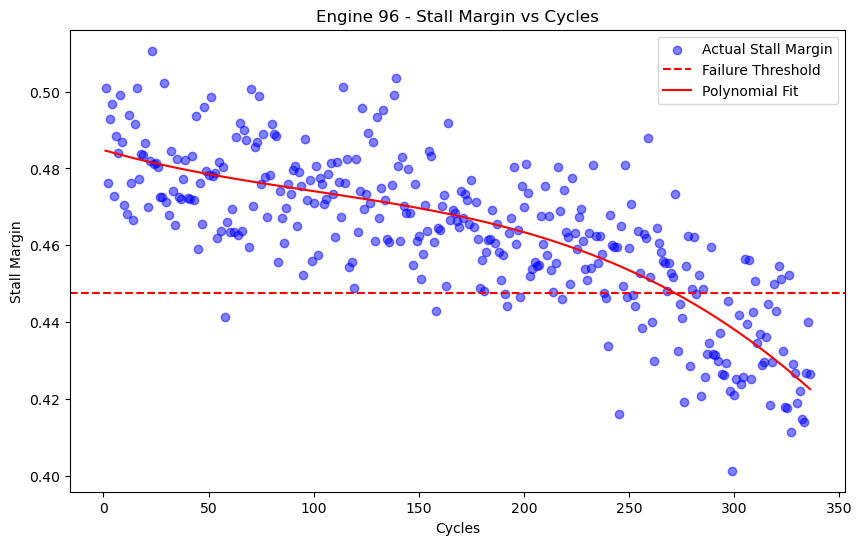

r2 score is:0.5731472605347563


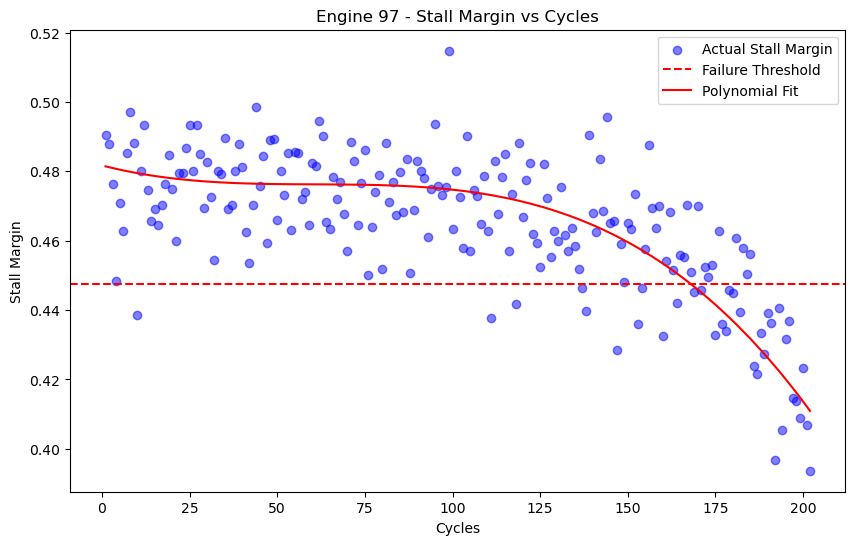

r2 score is:0.6622283607328902


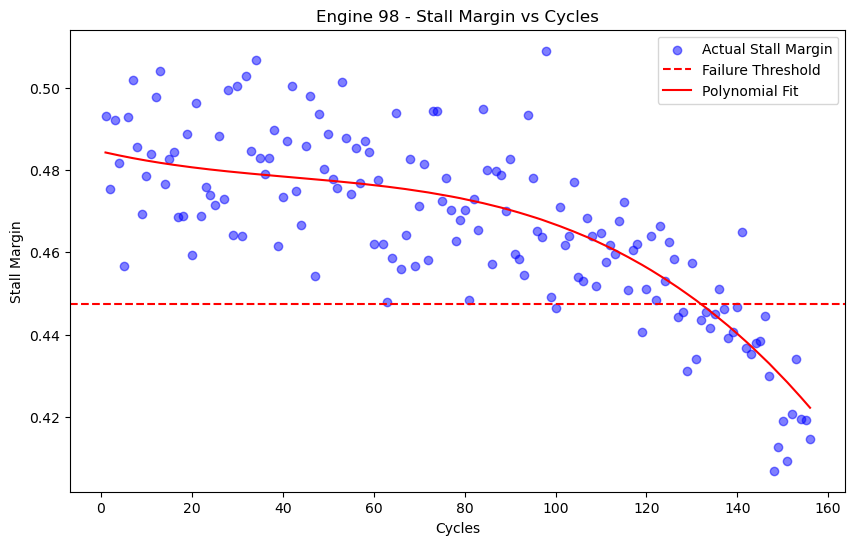

r2 score is:0.18841259629061247


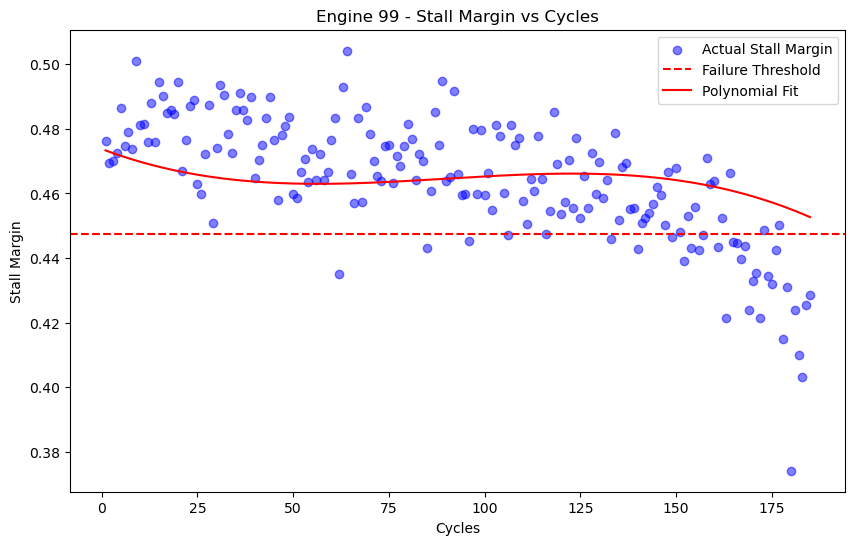

r2 score is:0.5860551309903361


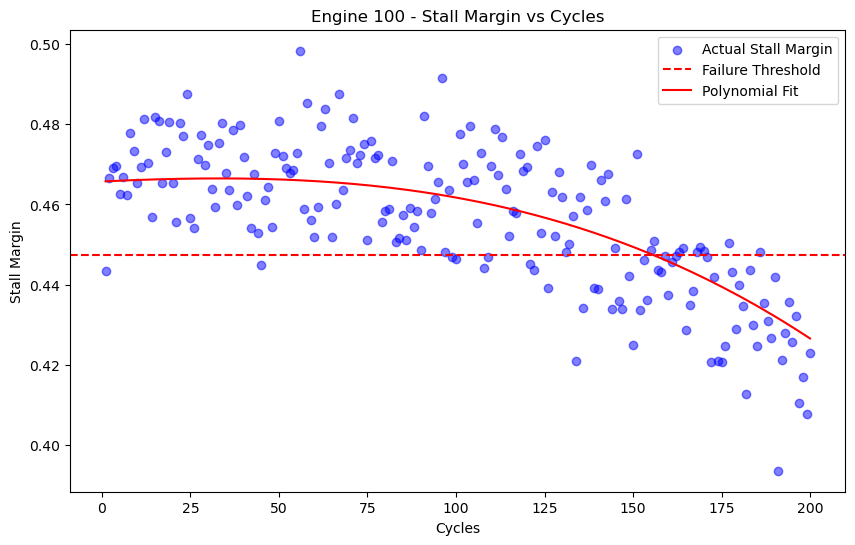

In [102]:
 #Get a list of unique engine numbers
unique_engines = FD001_data['Engine'].unique()

# Initialize a list to store results
engine_results = []
#to capture the variance portions of each model
##Check the logic of this object and it's functions
r2_scores_data = []

# Loop through each engine and fit a model
for engine in unique_engines:
    # Filter data for the current engine
    engine_data = FD001_data[FD001_data['Engine'] == engine]
    
    # Adding Features so that model can capture variance in the data effectively for HPC failure
    X = engine_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
    y = engine_data['stall_margin']
    
    #Creating poly model
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    model = LinearRegression(fit_intercept=True).fit(X_poly, y)
    
    # Store the model and data
    engine_results.append({
        'engine': engine,
        'model': model,
        'X_poly': X_poly,
        'y': y
    })
    
    # Predict the stall margin using the model
    y_pred = model.predict(X_poly)

    #Calculate R2 score
    r2_poly_agg = r2_score(y,y_pred)
    print(f'r2 score is:{r2_poly_agg}')
    r2_scores_data.append(r2_poly_agg)
    
    # Scatter plot for actual stall margin vs cycles
    plt.figure(figsize=(10, 6))
    plt.scatter(engine_data['Cycles'], y, color='blue', alpha=0.5, label='Actual Stall Margin')
    plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
    plt.plot(engine_data['Cycles'], y_pred, color='red', label='Polynomial Fit')
    plt.title(f'Engine {engine} - Stall Margin vs Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Stall Margin')
    plt.legend()
    plt.show()


(array([ 2.,  3.,  3.,  3.,  7., 11., 15., 18., 28., 10.]),
 array([0.14509268, 0.20186344, 0.25863421, 0.31540498, 0.37217575,
        0.42894652, 0.48571729, 0.54248806, 0.59925883, 0.6560296 ,
        0.71280037]),
 <BarContainer object of 10 artists>)

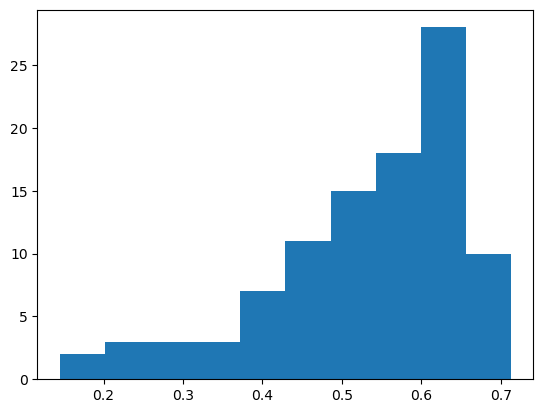

In [112]:
plt.hist(r2_scores_data)

In [103]:
#Creating RUL based on observations above

In [104]:
#FD001_data['RUL'] = (stall_margin - stall_margin_failure_threshold

max_engine_cycles = FD001_data.groupby("Engine")[['Cycles']].agg(max)
print(type(max_engine_cycles.info()))
print(max_engine_cycles)


#FD001_data['RUL-actual'] = FD001_data.groupby("Engine")[["Cycles"]].agg(max)

#print(FD001_data.head(20))

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 1 to 100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Cycles  100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
<class 'NoneType'>
        Cycles
Engine        
1          192
2          287
3          179
4          189
5          269
6          188
7          259
8          150
9          201
10         222
11         240
12         170
13         163
14         180
15         207
16         209
17         276
18         195
19         158
20         234
21         195
22         202
23         168
24         147
25         230
26         199
27         156
28         165
29         163
30         194
31         234
32         191
33         200
34         195
35         181
36         158
37         170
38         194
39         128
40         188
41         216
42         196
43         207
44         192
45         158
46         256
47         214
48  

Curious about what I can find using clustering model

In [105]:
X = FD001_data
scale = StandardScaler()
X_scale = scale.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scale)


In [106]:
# Perform KMeans clustering
optimal_clusters = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_pca)


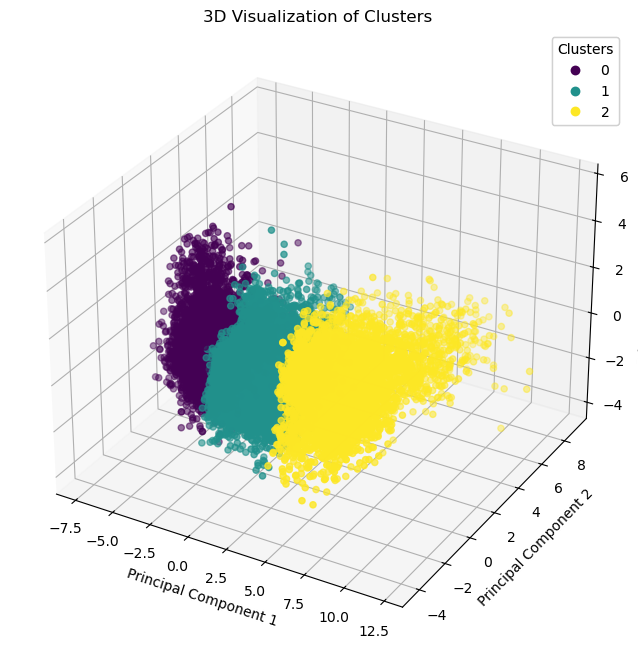

In [107]:
# 3D scatter plot of the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', marker='o')

# Adding title and labels
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding color bar to indicate cluster labels
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()